In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D
import userinput
import glob

if userinput.Depth_drilling_possible:
    folder = "optimization_2_results_depth"
else:
    folder = "optimization_2_results"
csv_files = [f for f in os.listdir(folder) if f.endswith('.csv')]

df_temp_time = pd.read_csv('csv_and_xlsx/Analysis_I_temp_time.csv')
df_temp_time.index = pd.to_datetime(df_temp_time['time'])
df_temp_time = df_temp_time.drop(columns=['Unnamed: 0', 'time'])


plotwidth = (6.3, 4)
fontsize_min = 18
fontsize_maj = 25

In [2]:
# Find the basecase CSV file in the optimization_1_basecase folder
basecase_folder = "optimization_1_basecase"
basecase_files = glob.glob(os.path.join(basecase_folder, "01*.csv"))
if basecase_files:
    basecase_file = os.path.basename(basecase_files[0])
    # Remove prefix
    highlight_name = basecase_file[len("01_ATES_default_"):]
    basecase = pd.read_csv(basecase_files[0])
else:
    highlight_name = None
    basecase = None


In [3]:
all_dfs = pd.DataFrame(columns=['name', 'phi_standing', 'phi_charge', 'electricity_price', 'drilling_costs', 'Capex_TTES', 'objective_value', 'total_heat_supplied', 'total_heat_demand', 'costs_per_MWh_produced','costs_per_MWh_demand','ATES_capacity','ATES_max_power','ATES_charge_sum','ATES_discharge_sum','heatpump_sum','eboiler_sum','heatpump_ATES_sum','eboiler_ATES_sum','TTES_charge_sum','TTES_discharge_sum'])
lower_costs_df = all_dfs.copy() 
higher_costs_df = all_dfs.copy()
num_cheaper = 0
num_expensive = 0
for f in csv_files:
    name = f
    f = pd.read_csv(os.path.join(folder, f))
#entries:
#datetime,ATES_capacity,ATES_power,ATES_discharge,ATES_charge,ATES_soc,capacity_eb,eboiler,capacity_hp,heatpump,capacity_hp_ATES,heatpump_ATES,capacity_eb_ATES,eboiler_ATES,TTES_capacity,TTES_charge,TTES_soc,ATES_discharge_limit,ATES_charge_limit,ATES_cap_limit,eb_limit,hp_limit,hp_ATES_limit,eb_ATES_limit,ATES-EB-partition1,ATES-EB-partition2,ATES_soc_initial,ATES_soc_consistency,ATES_soc_final,TTES_cap_limit,TTES_soc_initial,TTES_soc_consistency,TTES_soc_final,energy_balance,ATES_discharge_ramping_up,ATES_discharge_ramping_down,phi_standing,electricity_price,drilling_costs,Capex_TTES,objective_value,total_heat_supplied,costs_per_MWh_produced,costs_per_MWh_demand
#ATES_discharge,ATES_charge,eboiler,heatpump,heatpump_ATES,eboiler_ATES,TTES_charge
    df_aux = pd.DataFrame({
        'name': [name],
        'phi_standing': [f['phi_standing'].iloc[0]],
        'phi_charge': [f['phi_charge'].iloc[0]],
        'electricity_price': [f['electricity_price'].iloc[0]],
        'drilling_costs': [f['drilling_costs'].iloc[0]],
        'Capex_TTES': [f['Capex_TTES'].iloc[0]],
        'objective_value': [f['objective_value'].iloc[0]],
        'total_heat_demand': [f['heat_demand'].sum()],
        'total_heat_supplied': [f['total_heat_supplied'].iloc[0]],
        'costs_per_MWh_produced': [f['costs_per_MWh_produced'].iloc[0]],
        'costs_per_MWh_demand': [f['costs_per_MWh_demand'].iloc[0]],
        'ATES_capacity': [f['ATES_capacity'].iloc[0]],
        'ATES_max_power': [f['ATES_power'].iloc[0]],
        'ATES_charge_sum': [f['ATES_charge'].sum()],
        'ATES_discharge_sum': [f['ATES_discharge'].sum()],
        'heatpump_sum': [f['heatpump'].sum()],
        'eboiler_sum': [f['eboiler'].sum()],
        'heatpump_ATES_sum': [f['heatpump_ATES'].sum()],
        'eboiler_ATES_sum': [f['eboiler_ATES'].sum()],
        'TTES_charge_sum': [f['TTES_charge'][f['TTES_charge'] > 0].sum()],
        'TTES_discharge_sum': [-f['TTES_charge'][f['TTES_charge'] < 0].sum()]
    })
    all_dfs = pd.concat([all_dfs, df_aux], ignore_index=True)
    # Create Dataframes of higher and lower costs

    if basecase is not None:
        current_cost = f['costs_per_MWh_demand'].iloc[0]
        base_cost = basecase.costs_per_MWh_demand.iloc[0]
        tol = 1e-3  # or whatever fits your scale
        if abs(current_cost - base_cost) < tol:
            higher_costs_df = pd.concat([higher_costs_df, df_aux], ignore_index=True)
            lower_costs_df = pd.concat([lower_costs_df, df_aux], ignore_index=True)
            num_cheaper += 1
            num_expensive += 1
        elif current_cost < base_cost:
            lower_costs_df = pd.concat([lower_costs_df, df_aux], ignore_index=True)
            num_cheaper += 1
        else:
            higher_costs_df = pd.concat([higher_costs_df, df_aux], ignore_index=True)
            num_expensive += 1
lower_costs_df.sort_values(by='costs_per_MWh_demand', ascending=False, inplace=True)   
higher_costs_df.sort_values(by='costs_per_MWh_demand', ascending=True, inplace=True)         


# plots of soc over time for grouped phi and elpr

grouped = all_dfs.groupby(['phi_standing', 'electricity_price'])
for idx, ((phi, price), group) in enumerate(grouped):
    num_group_files = len(all_dfs[(all_dfs['phi_standing'] == phi) & (all_dfs['electricity_price'] == price)])

    red_cmap = matplotlib.colormaps['Reds'].resampled(num_group_files)
    blue_cmap = matplotlib.colormaps['Blues'].resampled(num_group_files)

    plt.figure(figsize=(15, 6))
    handles = []
    labels = []
    color_idx = 0
    for fname in group['name']:
        df_path = os.path.join(folder, fname)
        df = pd.read_csv(df_path)
        h1, = plt.plot(df['ATES_soc'], color=red_cmap(color_idx), label=f'{fname} ATES_soc')
        h2, = plt.plot(df['TTES_soc'], color=blue_cmap(color_idx), label=f'{fname} TTES_soc')
        handles.extend([h1, h2])
        labels.extend([f'{fname} ATES_soc', f'{fname} TTES_soc'])
        color_idx += 1
    plt.title(f'phi_standing: {phi}, electricity_price: {price}')
    plt.xlabel('Index')
    plt.ylabel('State of Charge')
    tick_locs = range(15*24, len(df['datetime']), 8760 // 12)
    tick_labels = pd.to_datetime(df['datetime']).dt.strftime('%b')[list(tick_locs)]
    plt.xticks(ticks=tick_locs, labels=tick_labels, rotation=45)
    #plt.ylim(0, 7500)
    plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize='xx-small')
    plt.tight_layout()
    plt.show()

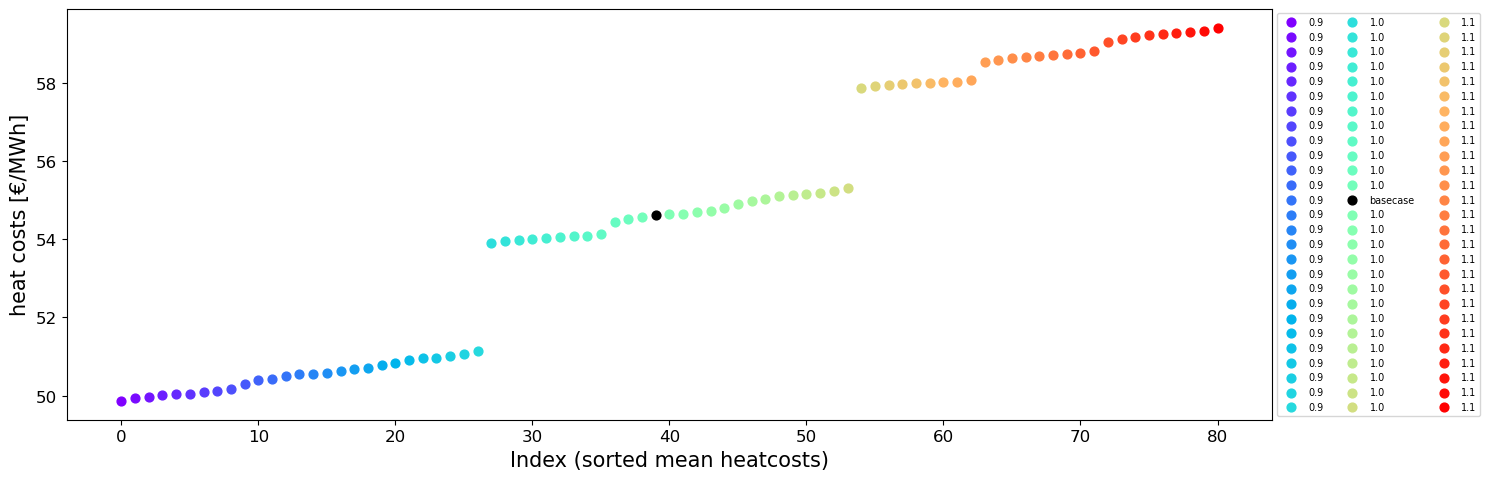

In [4]:
plt.figure(figsize=(15, 5))
heat_costs = all_dfs.sort_values(['costs_per_MWh_demand'], ascending=True)
num_points = len(heat_costs)
rainbow_cmap = matplotlib.colormaps['rainbow'].resampled(num_points)
colors = [rainbow_cmap(i) for i in range(num_points)]

highlight_idx = None
for i, (idx, row) in enumerate(heat_costs.iterrows()):
    color = 'black' if row['name'] == highlight_name else colors[i]
    label = 'basecase' if row['name'] == highlight_name else f"{row['electricity_price']}"
    plt.scatter(i, row['costs_per_MWh_demand'], color=color, s=40, label=label)
    if row['name'] == highlight_name:
        highlight_idx = i

plt.xlabel('Index (sorted mean heatcosts)', fontsize=15)
plt.ylabel('heat costs [€/MWh]', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=12)
if highlight_idx is not None:
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='x-small',ncol=3)
plt.tight_layout()
plt.savefig(os.path.join("RESULTS_PDFs", "Mean System Heat Costs for different electricity price factors (0.9 to 1.1).pdf"), bbox_inches='tight')
plt.show()

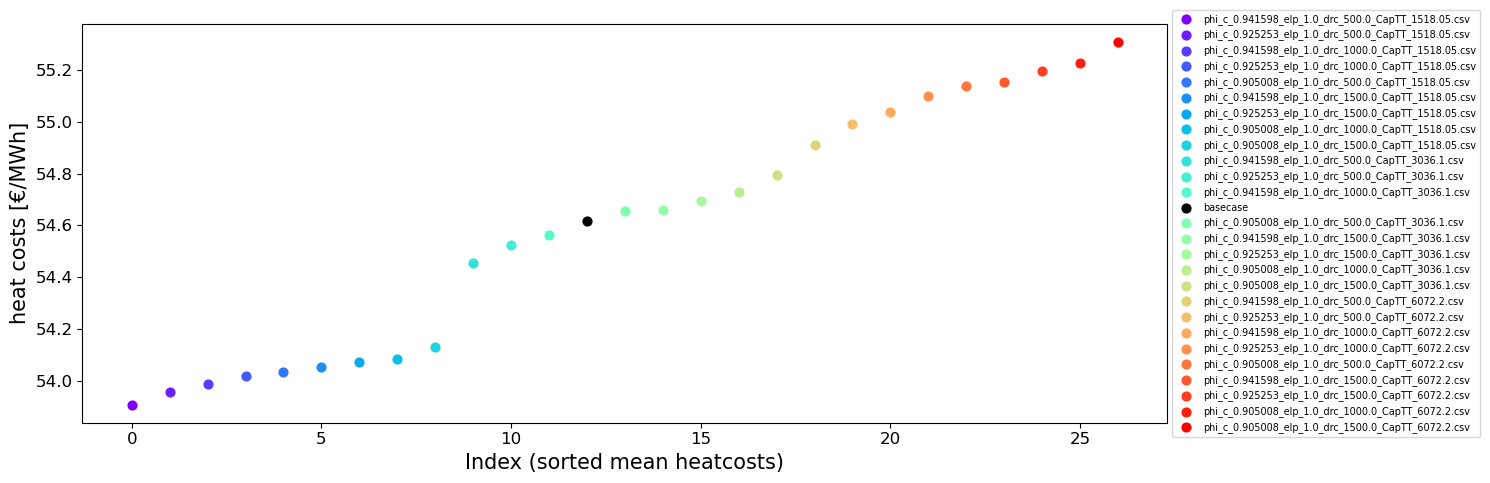

In [5]:
plt.figure(figsize=(15, 5))
heat_costs_el1 = all_dfs[all_dfs["electricity_price"] == 1.0].sort_values(['costs_per_MWh_demand'], ascending=True)
num_points = len(heat_costs_el1)
rainbow_cmap = matplotlib.colormaps['rainbow'].resampled(num_points)
colors = [rainbow_cmap(i) for i in range(num_points)]

highlight_idx = None
for i, (idx, row) in enumerate(heat_costs_el1.iterrows()):
    color = 'black' if row['name'] == highlight_name else colors[i]
    label = 'basecase' if row['name'] == highlight_name else f"{row['name']}"
    plt.scatter(i, row['costs_per_MWh_demand'], color=color, s=40, label=label)
    if row['name'] == highlight_name:
        highlight_idx = i

plt.xlabel('Index (sorted mean heatcosts)', fontsize=15)
plt.ylabel('heat costs [€/MWh]', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=12)

if highlight_idx is not None:
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='x-small',ncol=1)
plt.tight_layout()
plt.savefig(os.path.join("RESULTS_PDFs", "Mean System Heat Costs for electricity_price factor 1.0.pdf"), bbox_inches='tight')
plt.show()

In [6]:
from IPython.display import HTML, display
import os
import numpy as np
import pandas as pd

heat_costs = all_dfs.sort_values(['costs_per_MWh_demand'], ascending=True)
num_points = len(heat_costs)
rainbow_cmap = matplotlib.colormaps['rainbow'].resampled(num_points)
colors = [rainbow_cmap(i) for i in range(num_points)]



# Arrange table data into 3 columns, sorted vertically
def chunk_vertical(data, n_cols):
    n_rows = (len(data) + n_cols - 1) // n_cols
    columns = [data[i*n_rows:(i+1)*n_rows] for i in range(n_cols)]
    for col in columns:
        while len(col) < n_rows:
            col.append(('', '', '', '', '', '', ''))
    return list(zip(*columns))

# Rebuild table_data to include phi_charge (placed before phi_standing)
table_data = []
for i, (idx, row) in enumerate(heat_costs.iterrows()):
    color = 'black' if row['name'] == highlight_name else matplotlib.colors.rgb2hex(colors[i])
    dot_html = (
        f"<span style='display:inline-flex;align-items:center;justify-content:center;"
        f"width:20px;height:20px;border-radius:50%;background:{color};"
        f"color:white;font-weight:bold;font-size:13px;'>{i+1}</span>"
    )
    cost_display = f"{row['costs_per_MWh_demand']:.2f}"
    price_display = f"{row['electricity_price']:.1f}"
    # phi_charge may be missing in some rows => use get with fallback
    phi_charge_val = row.get('phi_charge', np.nan) if hasattr(row, "get") else row['phi_charge']
    phi_charge_display = f"{phi_charge_val:.6f}" if not pd.isna(phi_charge_val) else ""
    phi_display = f"{row['phi_standing']:.6f}"
    drill_display = f"{row['drilling_costs']:.0f}"
    cap_TTES_display = f"{row['Capex_TTES']:.0f}"
    ates_power_display = f"{row['ATES_max_power']:.3f}"
    # tuple now: dot, cost, price, phi_charge, phi_standing, drilling, cap_TTES
    table_data.append((dot_html, cost_display, price_display, phi_charge_display, phi_display, drill_display, cap_TTES_display, ates_power_display))

table_data_II = table_data.copy()
# Sort table_data_II by ates_power_display (the 8th element, index 7, as float)
table_data_II = sorted(table_data_II, key=lambda x: float(x[7]))

n_cols = 3
vertical_rows = chunk_vertical(table_data, n_cols)

# Build HTML table with 3 columns, sorted vertically
html = """
<style>
table, th, td {
    font-family: Arial, Helvetica, sans-serif;
    font-size: 14px;
    text-align: center;
}
th {
    background: black;
    color: white;
    font-weight: bold;
    white-space: nowrap;
}
span {
    font-weight: normal;
    font-size: 12px;
}
</style>
<table style='width:100%; border-collapse:collapse; background:white;'>
"""
header_cells = [
    ("", ""),  # For the dot column
    ("Heat Cost", "[€/MWh]"),
    ("El. Pr. Fac.", "[-]"),
    ("Phi charge", "[-]"),
    ("Phi standing", "[-]"),
    ("Drilling", "[€/m]"),
    ("Capex TTES", "[€/MWh]"),
    ("ATES P", "[MW]")
]
html += "<tr style='background:black; color:white; font-weight:bold;'>"
for col_idx in range(n_cols * len(header_cells)):
    # Add border-right except for the last header cell
    border = "border-right:2px solid white;" if (col_idx + 1) % (len(header_cells)) != 0 else ""
    name, unit = header_cells[col_idx % len(header_cells)]
    html += f"<th style='text-align:center; white-space:nowrap; {border}'>{name}<br><span style='font-weight:normal; font-size:12px;'>{unit}</span></th>"
for row_group in vertical_rows:
    html += "<tr style='color:black; background:white;'>"
    for dot, cost, price, phi_charge, phi, drill, cap_TTES, ates_power in row_group:
        html += (
            f"<td style='text-align:center;'>{dot}</td>"
            f"<td style='text-align:center;'>{cost}</td>"
            f"<td style='text-align:center;'>{price}</td>"
            f"<td style='text-align:center;'>{phi_charge}</td>"
            f"<td style='text-align:center;'>{phi}</td>"
            f"<td style='text-align:center;'>{drill}</td>"
            f"<td style='text-align:center;'>{cap_TTES}</td>"
            f"<td style='text-align:center;'>{ates_power}</td>"
        )
    html += "</tr>"
    html += "</tr>"
html += "</table>"

display(HTML(html))
os.makedirs("RESULTS_html", exist_ok=True)
html_path = os.path.join("RESULTS_html", "Heat_Cost_Table.html")
with open(html_path, "w", encoding="utf-8") as f:
    f.write(html)



os.makedirs("RESULTS_html", exist_ok=True)
html_path = os.path.join("RESULTS_html", "Heat_Cost_Table_ATES_P.html")
with open(html_path, "w", encoding="utf-8") as f:
    f.write(html)
    # compute phi_charge (use existing column if present, otherwise derive from ATES/TTES charge sums)

    if 'phi_charge' in heat_costs.columns:
        phi_series = heat_costs['phi_charge']
    else:
        ates_ch = heat_costs.get('ATES_charge_sum', pd.Series(0, index=heat_costs.index))
        ttes_ch = heat_costs.get('TTES_charge_sum', pd.Series(0, index=heat_costs.index))
        denom = heat_costs['total_heat_demand'].replace(0, np.nan)
        phi_series = (ates_ch.fillna(0) + ttes_ch.fillna(0)) / denom

    # update table_data entries: 4th element in each tuple is the phi_charge display
    updated_table = []
    for i, entry in enumerate(table_data_II):
        phi_val = phi_series.iloc[i] if i < len(phi_series) else np.nan
        phi_str = f"{phi_val:.6f}" if not pd.isna(phi_val) else ""
        parts = list(entry)
        parts[3] = phi_str
        updated_table.append(tuple(parts))
    table_data_II = updated_table

    # rebuild vertical layout and the table HTML body, then overwrite/display the updated HTML
    vertical_rows = chunk_vertical(table_data_II, n_cols)

    rows_html = ""
    for row_group in vertical_rows:
        rows_html += "<tr style='color:black; background:white;'>"
        for dot, cost, price, phi_charge, phi, drill, cap_TTES, ates_power in row_group:
            rows_html += (
                f"<td style='text-align:center;'>{dot}</td>"
                f"<td style='text-align:center;'>{cost}</td>"
                f"<td style='text-align:center;'>{price}</td>"
                f"<td style='text-align:center;'>{phi_charge}</td>"
                f"<td style='text-align:center;'>{phi}</td>"
                f"<td style='text-align:center;'>{drill}</td>"
                f"<td style='text-align:center;'>{cap_TTES}</td>"
                f"<td style='text-align:center;'>{ates_power}</td>"
            )
        rows_html += "</tr>"

    # build full HTML (style + header + rows) and write/display it
    html_updated = """
    <style>
    table, th, td {
        font-family: Arial, Helvetica, sans-serif;
        font-size: 14px;
        text-align: center;
    }
    th {
        background: black;
        color: white;
        font-weight: bold;
        white-space: nowrap;
    }
    span {
        font-weight: normal;
        font-size: 12px;
    }
    </style>
    <table style='width:100%; border-collapse:collapse; background:white;'>
    """
    header_cells = [
        ("", ""),  # For the dot column
        ("Heat Cost", "[€/MWh]"),
        ("El. Pr. Fac.", "[-]"),
        ("Phi charge", "[-]"),
        ("Phi standing", "[-]"),
        ("Drilling", "[€/m]"),
        ("Capex TTES", "[€/MWh]"),
        ("ATES P", "[MW]")
    ]
    html_updated += "<tr style='background:black; color:white; font-weight:bold;'>"
    for col_idx in range(n_cols * len(header_cells)):
        border = "border-right:2px solid white;" if (col_idx + 1) % (len(header_cells)) != 0 else ""
        name, unit_txt = header_cells[col_idx % len(header_cells)]
        html_updated += f"<th style='text-align:center; white-space:nowrap; {border}'>{name}<br><span style='font-weight:normal; font-size:12px;'>{unit_txt}</span></th>"
    html_updated += "</tr>"
    html_updated += rows_html
    html_updated += "</table>"

    display(HTML(html_updated))

    with open(html_path, "w", encoding="utf-8") as f:
        f.write(html_updated)




In [7]:
def get_phi_group(val):
    return f"{float(val):.3f}"

phi_groups = {}
for entry in table_data:
    phi_charge = get_phi_group(entry[3])
    if phi_charge not in phi_groups:
        phi_groups[phi_charge] = []
    phi_groups[phi_charge].append(entry)

# Sort each group by system price (entry[1], as float), descending
for phi_charge in phi_groups:
    phi_groups[phi_charge].sort(key=lambda x: float(x[1]), reverse=False)

# Prepare columns for the table (3 columns for 3 phi_charge groups)
phi_keys = sorted(phi_groups.keys(), reverse=True)
n_cols = len(phi_keys)
n_rows = max(len(phi_groups[k]) for k in phi_keys)

columns = []
for k in phi_keys:
    col = phi_groups[k]
    while len(col) < n_rows:
        col.append(('', '', '', '', '', '', '', ''))
    columns.append(col)

vertical_rows = list(zip(*columns))

html = """
<style>
table, th, td {
    font-family: Arial, Helvetica, sans-serif;
    font-size: 14px;
    text-align: center;
}
th {
    background: black;
    color: white;
    font-weight: bold;
    white-space: nowrap;
}
span {
    font-weight: normal;
    font-size: 12px;
}
</style>
<table style='width:100%; border-collapse:collapse; background:white;'>
"""

header_cells = [
    ("", ""),  # For the dot column
    ("Heat Cost", "[€/MWh]"),
    ("El. Pr. Fac.", "[-]"),
    ("Phi charge", "[-]"),
    ("Phi standing", "[-]"),
    ("Drilling", "[€/m]"),
    ("Capex TTES", "[€/MWh]"),
    ("ATES P", "[MW]")
]
html += "<tr style='background:black; color:white; font-weight:bold;'>"
for idx, _ in enumerate(phi_keys):
    border = "border-right:2px solid white;" if (idx + 1) % (len(header_cells)) != 0 else ""
    for name, unit in header_cells:
        html += f"<th style='text-align:center; white-space:nowrap; {border}'>{name}<br><span style='font-weight:normal; font-size:12px;'>{unit}</span></th>"
html += "</tr>"

for row_group in vertical_rows:
    html += "<tr style='color:black; background:white;'>"
    for dot, cost, price, phi_charge, phi, drill, cap_TTES, ates_power in row_group:
        html += (
            f"<td style='text-align:center;'>{dot}</td>"
            f"<td style='text-align:center;'>{cost}</td>"
            f"<td style='text-align:center;'>{price}</td>"
            f"<td style='text-align:center;'>{phi_charge}</td>"
            f"<td style='text-align:center;'>{phi}</td>"
            f"<td style='text-align:center;'>{drill}</td>"
            f"<td style='text-align:center;'>{cap_TTES}</td>"
            f"<td style='text-align:center;'>{ates_power}</td>"
        )
    html += "</tr>"
html += "</table>"

display(HTML(html))

os.makedirs("RESULTS_html", exist_ok=True)
html_path = os.path.join("RESULTS_html", "Heat_Cost_Table_phi_charge_columns.html")
with open(html_path, "w", encoding="utf-8") as f:
    f.write(html)


In [8]:
from IPython.display import HTML, display
import os
import numpy as np
import pandas as pd

heat_costs = all_dfs.sort_values(['costs_per_MWh_demand'], ascending=True)
num_points = len(heat_costs)
rainbow_cmap = matplotlib.colormaps['rainbow'].resampled(num_points)
colors = [rainbow_cmap(i) for i in range(num_points)]



# Arrange table data into 3 columns, sorted vertically
def chunk_vertical(data, n_cols):
    n_rows = (len(data) + n_cols - 1) // n_cols
    columns = [data[i*n_rows:(i+1)*n_rows] for i in range(n_cols)]
    for col in columns:
        while len(col) < n_rows:
            col.append(('', '', '', '', '', '', ''))
    return list(zip(*columns))

def get_phi_group(val):
    return f"{float(val):.3f}"

# Rebuild table_data to include phi_charge (placed before phi_standing)
table_data = []
for i, (idx, row) in enumerate(heat_costs.iterrows()):
    color = 'black' if row['name'] == highlight_name else matplotlib.colors.rgb2hex(colors[i])
    dot_html = (
        f"<span style='display:inline-flex;align-items:center;justify-content:center;"
        f"width:20px;height:20px;border-radius:50%;background:{color};"
        f"color:white;font-weight:bold;font-size:13px;'>{i+1}</span>"
    )
    cost_display = f"{row['costs_per_MWh_demand']:.2f}"
    ATES_discharge_display = f"{row['ATES_discharge_sum']:.1f}"
    phi_charge_display = f"{row['phi_charge']:.3f}" if not pd.isna(row['phi_charge']) else ""
    ATES_power_display = f"{row['ATES_max_power']:.3f}"
    ates_efficiency_display = f"{row['ATES_discharge_sum']/row['ATES_charge_sum']*100:.3f}" if row['ATES_charge_sum'] > 0 else ""
    ATES_charge = f"{row['ATES_charge_sum']:.3f}"
    ATES_share = f"{row['ATES_discharge_sum']/row['total_heat_demand']*100:.3f}" if row['ATES_capacity'] > 0 else ""
    # tuple now: dot, cost, price, phi_charge, phi_standing, drilling, cap_TTES
    table_data.append((dot_html, cost_display, ATES_discharge_display, phi_charge_display, ATES_power_display, ates_efficiency_display, ATES_charge, ATES_share))



for col_idx in range(n_cols * len(header_cells)):
    # Add border-right except for the last header cell
    border = "border-right:2px solid white;" if (col_idx + 1) % (len(header_cells)) != 0 else ""
    name, unit = header_cells[col_idx % len(header_cells)]
    html += f"<th style='text-align:center; white-space:nowrap; {border}'>{name}<br><span style='font-weight:normal; font-size:12px;'>{unit}</span></th>"



phi_groups = {}
for entry in table_data:
    phi_charge = get_phi_group(entry[3])
    if phi_charge not in phi_groups:
        phi_groups[phi_charge] = []
    phi_groups[phi_charge].append(entry)

# Sort each group by system price (entry[1], as float), descending
for phi_charge in phi_groups:
    phi_groups[phi_charge].sort(key=lambda x: float(x[1]), reverse=False)

# Prepare columns for the table (3 columns for 3 phi_charge groups)
phi_keys = sorted(phi_groups.keys(), reverse=True)
n_cols = len(phi_keys)
n_rows = max(len(phi_groups[k]) for k in phi_keys)

columns = []
for k in phi_keys:
    col = phi_groups[k]
    while len(col) < n_rows:
        col.append(('', '', '', '', '', '', '', ''))
    columns.append(col)

vertical_rows = list(zip(*columns))

html = """
<style>
table, th, td {
    font-family: Arial, Helvetica, sans-serif;
    font-size: 14px;
    text-align: center;
}
th {
    background: black;
    color: white;
    font-weight: bold;
    white-space: nowrap;
}
span {
    font-weight: normal;
    font-size: 12px;
}
</style>
<table style='width:100%; border-collapse:collapse; background:white;'>
"""

header_cells = [
    ("", ""),  # For the dot column
    ("Heat Cost", "[€/MWh]"),
    ("ATES P", "[MW]"),
    ("Phi c", "[-]"),
    ("ATES disch.", "[MWh]"),
    ("ATES ch.", "[-]"),
    ("ATES eff.", "[%]"),
    ("ATES share", "[%]")
]
html += "<tr style='background:black; color:white; font-weight:bold;'>"
for idx, _ in enumerate(phi_keys):
    border = "border-right:2px solid white;" if (idx + 1) % (len(header_cells)) != 0 else ""
    for name, unit in header_cells:
        html += f"<th style='text-align:center; white-space:nowrap; {border}'>{name}<br><span style='font-weight:normal; font-size:12px;'>{unit}</span></th>"
html += "</tr>"

for row_group in vertical_rows:
    html += "<tr style='color:black; background:white;'>"
    for dot, cost, discharge, phi_charge, ATES_pw, eff, charge, ATES_share in row_group:
        html += (
            f"<td style='text-align:center;'>{dot}</td>"
            f"<td style='text-align:center;'>{cost}</td>"
            f"<td style='text-align:center;'>{ATES_pw}</td>"
            f"<td style='text-align:center;'>{phi_charge}</td>"
            f"<td style='text-align:center;'>{discharge}</td>"
            f"<td style='text-align:center;'>{charge}</td>"
            f"<td style='text-align:center;'>{eff}</td>"
            f"<td style='text-align:center;'>{ATES_share}</td>"
        )
    html += "</tr>"
html += "</table>"

display(HTML(html))

os.makedirs("RESULTS_html", exist_ok=True)
html_path = os.path.join("RESULTS_html", "Heat_Cost_Table_varied_columns.html")
with open(html_path, "w", encoding="utf-8") as f:
    f.write(html)



In [9]:
# group by Capex_TTES and electricity_price and compute percent difference (relative to the minimum)
grp = all_dfs.groupby(['Capex_TTES', 'electricity_price'])['costs_per_MWh_produced'] \
             .agg(min_value='min', max_value='max', n='count') \
             .reset_index()

# percent difference relative to the lowest value (min); NaN if min <= 0 or only one sample
grp['pct_diff_vs_min'] = np.where(
    (grp['n'] > 1) & (grp['min_value'] > 0),
    (grp['max_value'] - grp['min_value']) / grp['min_value'] * 100,
    np.nan
)
# compute min/max of ATES_max_power per group and merge into grp, then percent diff vs min
power_stats = all_dfs.groupby(['Capex_TTES', 'electricity_price'])['ATES_max_power'] \
                     .agg(min_power='min', max_power='max').reset_index()
grp = grp.merge(power_stats, on=['Capex_TTES', 'electricity_price'], how='left')

grp['power_diff_vs_min'] = np.where(
    (grp['n'] > 1) & (grp['min_power'] > 0),
    (grp['max_power'] - grp['min_power']) / grp['min_power'] * 100,
    np.nan
)
# optional: sort by largest percentual difference
result = grp.sort_values('electricity_price', ascending=True).reset_index(drop=True)
# Build a copy and format columns for a clean LaTeX table
df_tex = result.copy()

# formatting
df_tex['Capex_TTES'] = df_tex['Capex_TTES'].astype(int)
df_tex['electricity_price'] = df_tex['electricity_price'].map(lambda x: f"{x:.2f}")
df_tex['min_value'] = df_tex['min_value'].map(lambda x: f"{x:.2f}")
df_tex['max_value'] = df_tex['max_value'].map(lambda x: f"{x:.2f}")
df_tex['pct_diff_vs_min'] = df_tex['pct_diff_vs_min'].map(
    lambda x: (f"{x:.2f}" if pd.notna(x) else "")
)
df_tex['power_diff_vs_min'] = df_tex['power_diff_vs_min'].map(
    lambda x: (f"{x:.2f}" if pd.notna(x) else "")
)

# drop the Samples column by not including 'n' in the final selection
df_tex = df_tex[['Capex_TTES', 'electricity_price', 'pct_diff_vs_min', 'power_diff_vs_min']].copy() # 'min_value', 'max_value', 

# create a MultiIndex: first row = title, second row = unit
df_tex.columns = pd.MultiIndex.from_tuples([
    ('Capex TTES', '\\relax[\euro{}/MWh]'),
    ('El. price fac.', '[-]'),
#    ('Min costs', '[\euro{}/MWh]'),
#    ('Max costs', '[\euro{}/MWh]'),
    ('Price diff', '[\%]'),
    ('Power diff', '[\%]')
])

# produce LaTeX and save as .tex for easy copy/paste
latex_str = df_tex.to_latex(index=False, escape=False, column_format='c c c c',
                            caption='Optimization results, grouped by Capex TTES and el- price fac., showing the difference in system costs and ATES power within each group.',
                            label='tab_grouped_results', longtable=False)

print(latex_str)

latex_str


\begin{table}
\caption{Optimization results, grouped by Capex TTES and el- price fac., showing the difference in system costs and ATES power within each group.}
\label{tab_grouped_results}
\begin{tabular}{c c c c}
\toprule
Capex TTES & El. price fac. & Price diff & Power diff \\
\relax[\euro{}/MWh] & [-] & [\%] & [\%] \\
\midrule
1518 & 0.90 & 0.63 & 83.62 \\
3036 & 0.90 & 0.93 & 41.19 \\
6072 & 0.90 & 0.99 & 39.97 \\
1518 & 1.00 & 0.47 & 54.53 \\
3036 & 1.00 & 0.76 & 43.15 \\
6072 & 1.00 & 0.87 & 36.22 \\
1518 & 1.10 & 0.42 & 53.42 \\
3036 & 1.10 & 0.58 & 52.10 \\
6072 & 1.10 & 0.71 & 31.50 \\
\bottomrule
\end{tabular}
\end{table}



'\\begin{table}\n\\caption{Optimization results, grouped by Capex TTES and el- price fac., showing the difference in system costs and ATES power within each group.}\n\\label{tab_grouped_results}\n\\begin{tabular}{c c c c}\n\\toprule\nCapex TTES & El. price fac. & Price diff & Power diff \\\\\n\\relax[\\euro{}/MWh] & [-] & [\\%] & [\\%] \\\\\n\\midrule\n1518 & 0.90 & 0.63 & 83.62 \\\\\n3036 & 0.90 & 0.93 & 41.19 \\\\\n6072 & 0.90 & 0.99 & 39.97 \\\\\n1518 & 1.00 & 0.47 & 54.53 \\\\\n3036 & 1.00 & 0.76 & 43.15 \\\\\n6072 & 1.00 & 0.87 & 36.22 \\\\\n1518 & 1.10 & 0.42 & 53.42 \\\\\n3036 & 1.10 & 0.58 & 52.10 \\\\\n6072 & 1.10 & 0.71 & 31.50 \\\\\n\\bottomrule\n\\end{tabular}\n\\end{table}\n'

In [10]:
all_dfs.sort_values(by='costs_per_MWh_demand', ascending=True).ATES_capacity

60    979.191724
33    874.114382
54    836.688857
27    775.919091
6     723.253095
         ...    
26    711.690248
77    724.180139
50    705.711187
20    692.170004
23    675.990924
Name: ATES_capacity, Length: 81, dtype: float64

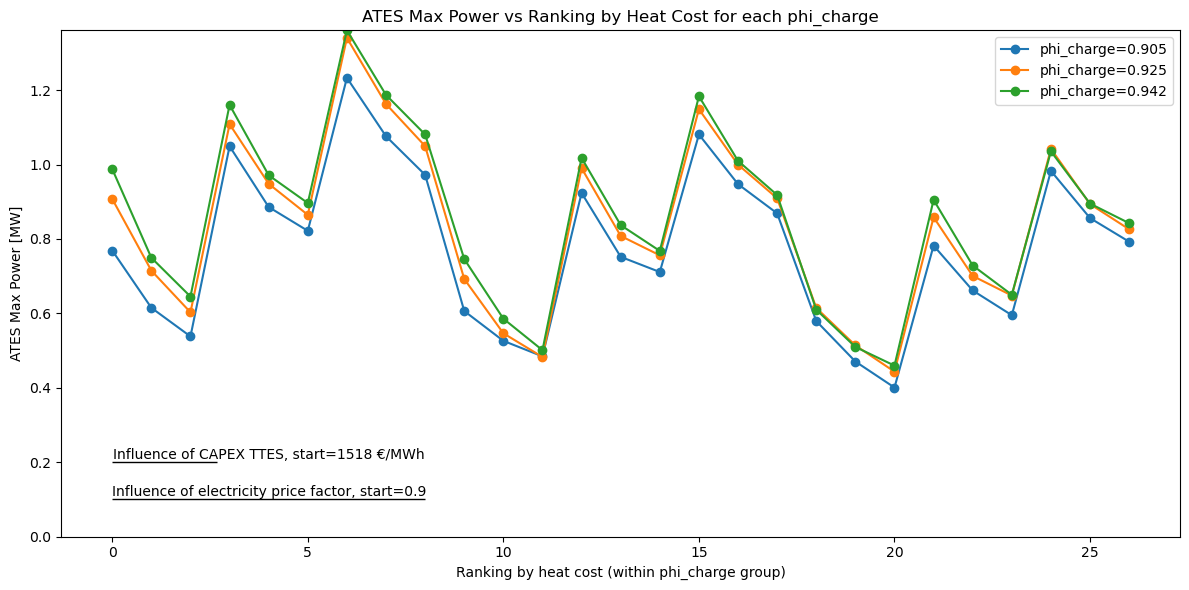

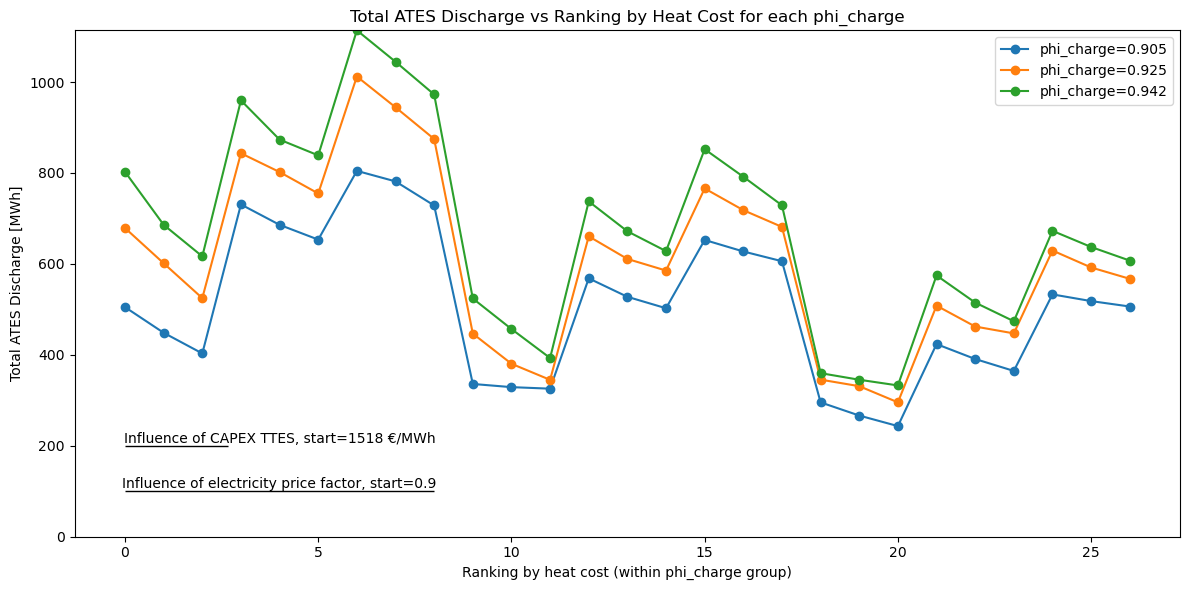

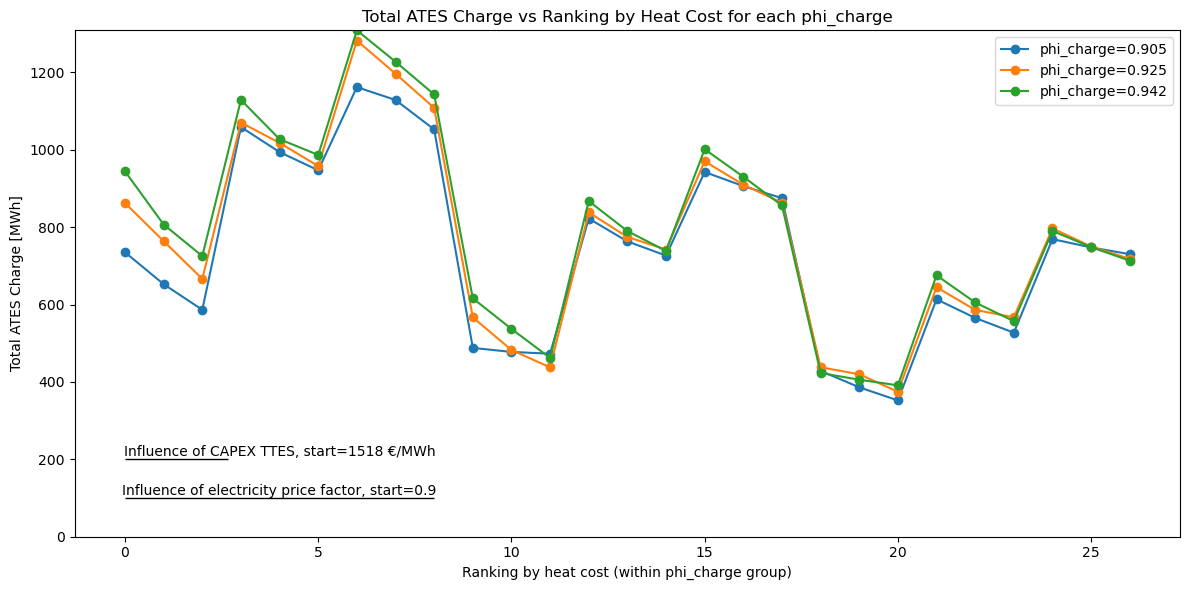

In [11]:
# First plot: ATES_max_power vs ranking (original)
grouped = all_dfs.groupby('phi_charge')
plt.figure(figsize=(12, 6))
for phi_charge, group in grouped:
    sorted_group = group.sort_values('costs_per_MWh_demand', ascending=True)
    x = range(len(sorted_group))
    y = sorted_group['ATES_max_power']
    plt.plot(x, y, marker='o', label=f'phi_charge={phi_charge:.3f}')
group_size = len(sorted_group)
plt.ylim(0, sorted_group['ATES_max_power'].max())
y_bottom = plt.ylim()[0]
end = int(1/3 * len(sorted_group) - 1)
plt.hlines(y=y_bottom + 0.1, xmin=0, xmax=end, color='black', linewidth=1)
plt.text((end) / 2, y_bottom + 0.1, 'Influence of electricity price factor, start=0.9',
         color='black', ha='center', va='bottom', fontsize=10)
end2 = end / 3
plt.hlines(y=y_bottom + 0.2, xmin=0, xmax=end2, color='black', linewidth=1)
plt.text((end) / 2, y_bottom + 0.2, 'Influence of CAPEX TTES, start=1518 €/MWh',
         color='black', ha='center', va='bottom', fontsize=10)
plt.xlabel('Ranking by heat cost (within phi_charge group)')
plt.ylabel('ATES Max Power [MW]')
plt.title('ATES Max Power vs Ranking by Heat Cost for each phi_charge')
plt.legend()
plt.tight_layout()
plt.show()

# Second plot: ATES_discharge_sum vs ranking (new)
grouped = all_dfs.groupby('phi_charge')
plt.figure(figsize=(12, 6))
for phi_charge, group in grouped:
    sorted_group = group.sort_values('costs_per_MWh_demand', ascending=True)
    x = range(len(sorted_group))
    y = sorted_group['ATES_discharge_sum']
    plt.plot(x, y, marker='o', label=f'phi_charge={phi_charge:.3f}')
group_size = len(sorted_group)
plt.ylim(0, sorted_group['ATES_discharge_sum'].max())
y_bottom = plt.ylim()[0]
end = int(1/3 * len(sorted_group) - 1)
plt.hlines(y=y_bottom + 100, xmin=0, xmax=end, color='black', linewidth=1)
plt.text((end) / 2, y_bottom + 100, 'Influence of electricity price factor, start=0.9',
         color='black', ha='center', va='bottom', fontsize=10)
end2 = end / 3
plt.hlines(y=y_bottom + 200, xmin=0, xmax=end2, color='black', linewidth=1)
plt.text((end) / 2, y_bottom + 200, 'Influence of CAPEX TTES, start=1518 €/MWh',
         color='black', ha='center', va='bottom', fontsize=10)
plt.xlabel('Ranking by heat cost (within phi_charge group)')
plt.ylabel('Total ATES Discharge [MWh]')
plt.title('Total ATES Discharge vs Ranking by Heat Cost for each phi_charge')
plt.legend()
plt.tight_layout()
plt.show()


# Third plot: ATES_charge_sum vs ranking (new)
grouped = all_dfs.groupby('phi_charge')
plt.figure(figsize=(12, 6))
for phi_charge, group in grouped:
    sorted_group = group.sort_values('costs_per_MWh_demand', ascending=True)
    x = range(len(sorted_group))
    y = sorted_group['ATES_charge_sum']
    plt.plot(x, y, marker='o', label=f'phi_charge={phi_charge:.3f}')
group_size = len(sorted_group)
plt.ylim(0, sorted_group['ATES_charge_sum'].max())
y_bottom = plt.ylim()[0]
end = int(1/3 * len(sorted_group) - 1)
plt.hlines(y=y_bottom + 100, xmin=0, xmax=end, color='black', linewidth=1)
plt.text((end) / 2, y_bottom + 100, 'Influence of electricity price factor, start=0.9',
         color='black', ha='center', va='bottom', fontsize=10)
end2 = end / 3
plt.hlines(y=y_bottom + 200, xmin=0, xmax=end2, color='black', linewidth=1)
plt.text((end) / 2, y_bottom + 200, 'Influence of CAPEX TTES, start=1518 €/MWh',
         color='black', ha='center', va='bottom', fontsize=10)
plt.xlabel('Ranking by heat cost (within phi_charge group)')
plt.ylabel('Total ATES Charge [MWh]')
plt.title('Total ATES Charge vs Ranking by Heat Cost for each phi_charge')
plt.legend()
plt.tight_layout()
plt.show()

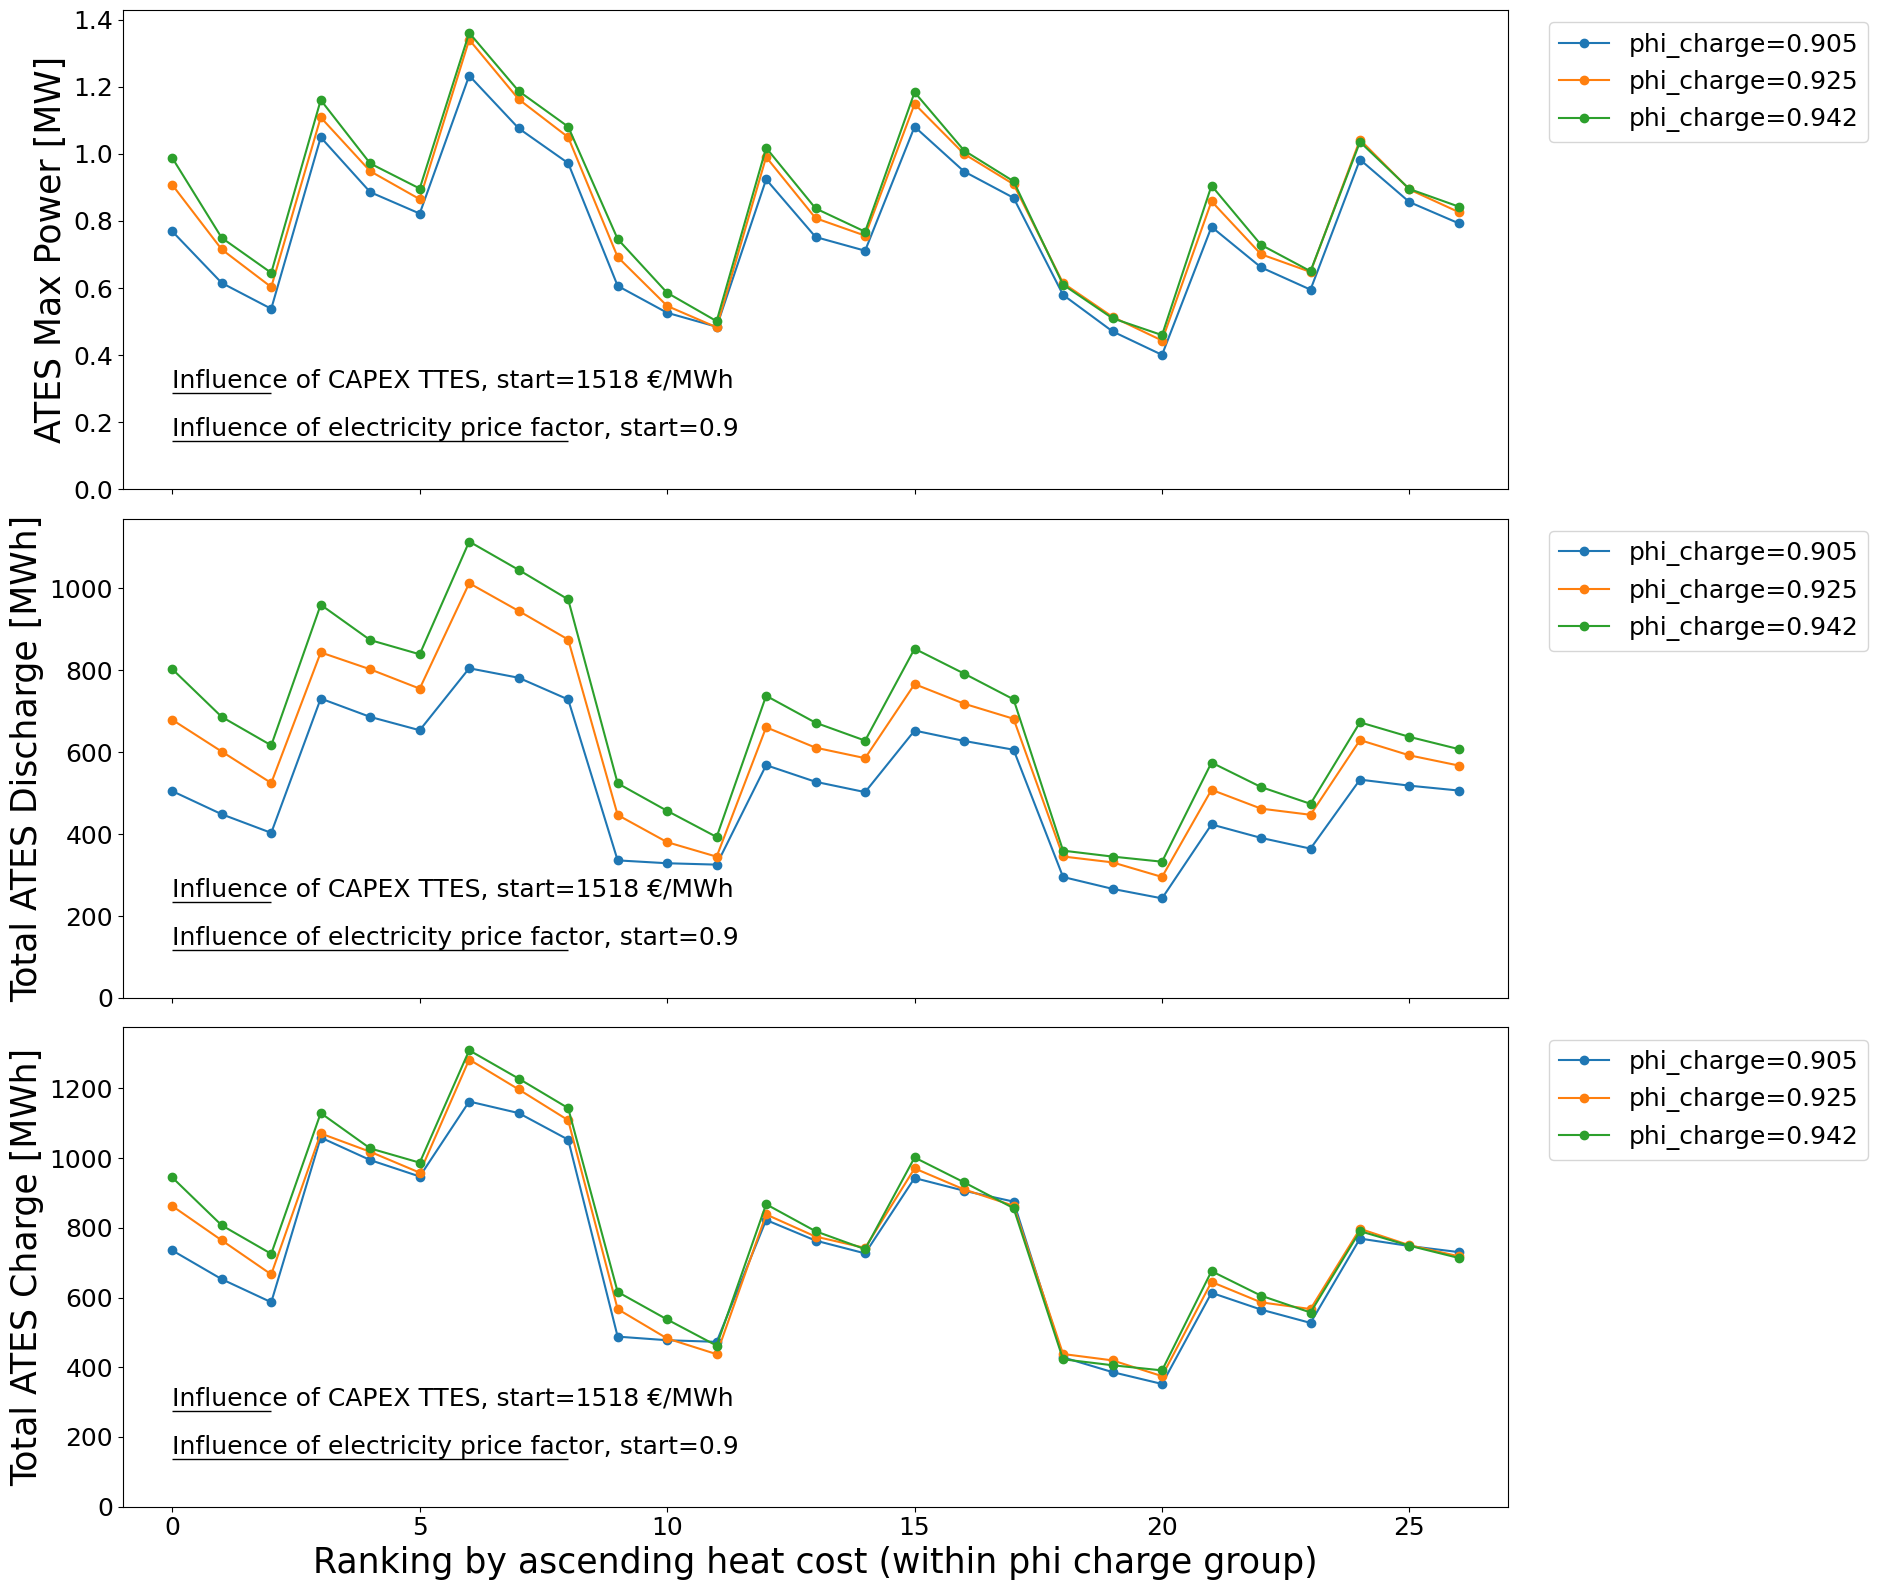

Saved figure to RESULTS_PDFs\grouped_ATES_Charge_Discharge_P.pdf


In [12]:
# combine the three related plots into one figure with 3 stacked subplots
groups = list(all_dfs.groupby('phi_charge'))

# compute maximum length for consistent x-axis range
max_len = max(len(g) for _, g in groups)

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(3*plotwidth[0], 4*plotwidth[1]))

axs[-1].set_xlim(-1, max_len-1 if max_len>0 else 0)

# --- top: ATES_max_power ---
ax = axs[0]
for phi_charge, group in groups:
    sorted_group = group.sort_values('costs_per_MWh_demand', ascending=True)
    x = range(len(sorted_group))
    y = sorted_group['ATES_max_power']
    ax.plot(x, y, marker='o', label=f'phi_charge={phi_charge:.3f}')
ax.set_ylim(0, all_dfs['ATES_max_power'].max() * 1.05)
ax.set_xlim(-1,max_len)
ymin, ymax = ax.get_ylim()
y_bottom = ymin
end = int(max_len/3)-1 if max_len>3 else max_len-1
# draw reference lines
ax.hlines(y=y_bottom + 0.1*(ymax-ymin), xmin=0, xmax=end  , color='black', linewidth=1)
ax.text(0, y_bottom + 0.1*(ymax-ymin), 'Influence of electricity price factor, start=0.9',
        color='black', ha='left', va='bottom', fontsize=fontsize_min)
end2 = max(1, int(end/3))
ax.hlines(y=y_bottom + 0.2*(ymax-ymin), xmin=0, xmax=end2, color='black', linewidth=1)
ax.text(0, y_bottom + 0.2*(ymax-ymin), 'Influence of CAPEX TTES, start=1518 €/MWh',
    color='black', ha='left', va='bottom', fontsize=fontsize_min)
ax.set_ylabel('ATES Max Power [MW]', fontsize = fontsize_maj)
ax.legend(fontsize=fontsize_min, bbox_to_anchor=(1.02, 1), loc='upper left')

# --- middle: ATES_discharge_sum ---
ax = axs[1]
for phi_charge, group in groups:
    sorted_group = group.sort_values('costs_per_MWh_demand', ascending=True)
    x = range(len(sorted_group))
    y = sorted_group['ATES_discharge_sum']
    ax.plot(x, y, marker='o', label=f'phi_charge={phi_charge:.3f}')
ax.set_ylim(0, all_dfs['ATES_discharge_sum'].max() * 1.05)
ymin, ymax = ax.get_ylim()
ax.hlines(y=ymin + 0.1*(ymax-ymin), xmin=0, xmax=end, color='black', linewidth=1)
ax.text(0, ymin + 0.1*(ymax-ymin), 'Influence of electricity price factor, start=0.9',
        color='black', ha='left', va='bottom', fontsize=fontsize_min)
ax.hlines(y=ymin + 0.20*(ymax-ymin), xmin=0, xmax=end2, color='black', linewidth=1)
ax.text(0, ymin + 0.20*(ymax-ymin), 'Influence of CAPEX TTES, start=1518 €/MWh',
        color='black', ha='left', va='bottom', fontsize=fontsize_min)
ax.set_ylabel('Total ATES Discharge [MWh]', fontsize = fontsize_maj)
ax.legend(fontsize=fontsize_min, bbox_to_anchor=(1.02, 1), loc='upper left')

# --- bottom: ATES_charge_sum (only this subplot shows x-ticks/labels) ---
ax = axs[2]
for phi_charge, group in groups:
    sorted_group = group.sort_values('costs_per_MWh_demand', ascending=True)
    x = range(len(sorted_group))
    y = sorted_group['ATES_charge_sum']
    ax.plot(x, y, marker='o', label=f'phi_charge={phi_charge:.3f}')
ax.set_ylim(0, all_dfs['ATES_charge_sum'].max() * 1.05)
ymin, ymax = ax.get_ylim()
ax.hlines(y=ymin + 0.1*(ymax-ymin), xmin=0, xmax=end, color='black', linewidth=1)
ax.text(0, ymin + 0.1*(ymax-ymin), 'Influence of electricity price factor, start=0.9',
        color='black', ha='left', va='bottom', fontsize=fontsize_min)
ax.hlines(y=ymin + 0.20*(ymax-ymin), xmin=0, xmax=end2, color='black', linewidth=1)
ax.text(0, ymin + 0.20*(ymax-ymin), 'Influence of CAPEX TTES, start=1518 €/MWh',
        color='black', ha='left', va='bottom', fontsize=fontsize_min)
ax.set_xlabel('Ranking by ascending heat cost (within phi charge group)', fontsize = fontsize_maj)
ax.set_ylabel('Total ATES Charge [MWh]', fontsize = fontsize_maj)
ax.legend(fontsize=fontsize_min, bbox_to_anchor=(1.02, 1), loc='upper left')
for ax in axs:
    ax.tick_params(axis='x', labelsize=fontsize_min)
    ax.tick_params(axis='y', labelsize=fontsize_min)
# hide x tick labels on the top two axes
for a in axs[:-1]:
    a.tick_params(labelbottom=False)

# set common x-limits and layout
plt.tight_layout()
plt.show()
os.makedirs("RESULTS_PDFs", exist_ok=True)
out_path = os.path.join("RESULTS_PDFs", "grouped_ATES_Charge_Discharge_P.pdf")
fig.savefig(out_path, bbox_inches='tight', dpi=300)
print(f"Saved figure to {out_path}")


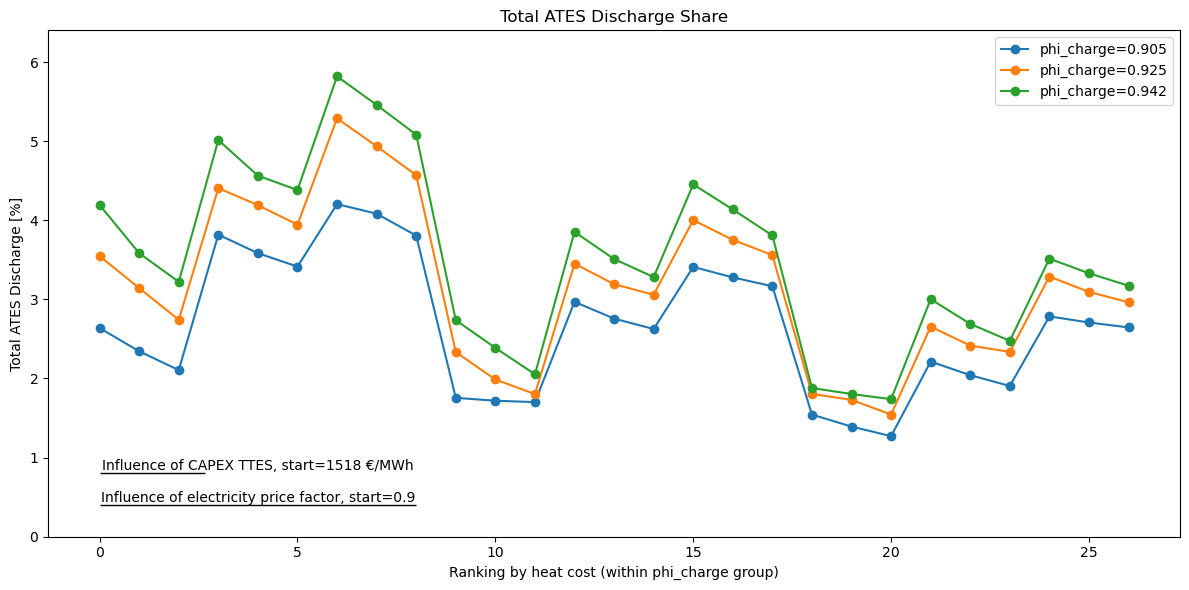

In [13]:
# Fourth plot: ATES_discharge_sum vs heat_demand 
grouped = all_dfs.groupby('phi_charge')
plt.figure(figsize=(12, 6))
for phi_charge, group in grouped:
    sorted_group = group.sort_values('costs_per_MWh_demand', ascending=True)
    x = range(len(sorted_group))
    y = sorted_group['ATES_discharge_sum']/sorted_group['total_heat_demand']*100
    plt.plot(x, y, marker='o', label=f'phi_charge={phi_charge:.3f}')
group_size = len(sorted_group)
plt.ylim(0, max(sorted_group['ATES_discharge_sum']/sorted_group['total_heat_demand']*110))
y_bottom = plt.ylim()[0]
end = int(1/3 * len(sorted_group) - 1)
plt.hlines(y=y_bottom + 0.4, xmin=0, xmax=end, color='black', linewidth=1)
plt.text((end) / 2, y_bottom + 0.4, 'Influence of electricity price factor, start=0.9',
         color='black', ha='center', va='bottom', fontsize=10)
end2 = end / 3
plt.hlines(y=y_bottom + 0.8, xmin=0, xmax=end2, color='black', linewidth=1)
plt.text((end) / 2, y_bottom + 0.8, 'Influence of CAPEX TTES, start=1518 €/MWh',
         color='black', ha='center', va='bottom', fontsize=10)
plt.xlabel('Ranking by heat cost (within phi_charge group)')
plt.ylabel('Total ATES Discharge [%]')
plt.title('Total ATES Discharge Share')
plt.legend()
plt.tight_layout()
plt.show()

#used to be plot for heat prices divided by electricity price now kinda pointless

plt.figure(figsize=(15, 5))
heat_costs = all_dfs.sort_values(['costs_per_MWh_demand'], ascending=True)
num_points = len(heat_costs)
rainbow_cmap = matplotlib.colormaps['rainbow'].resampled(num_points)
colors = [rainbow_cmap(i) for i in range(num_points)]

highlight_idx = None
for i, (idx, row) in enumerate(heat_costs.iterrows()):
    color = 'black' if row['name'] == highlight_name else colors[i]
    label = 'basecase' if row['name'] == highlight_name else f"{row['electricity_price']}"
    plt.scatter(i, row['costs_per_MWh_demand']/df_temp_time['electricity_price'].mean(), color=color, s=40, label=label)
    if row['name'] == highlight_name:
        highlight_idx = i

plt.xlabel('Index (sorted mean heatcosts)', fontsize=15)
plt.ylabel('heat costs [€/MWh]', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=12)
if highlight_idx is not None:
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='x-small',ncol=3)
plt.tight_layout()
plt.savefig(os.path.join("RESULTS_PDFs", "Mean System Heat Costs normalized by electricity price factors (0.9 to 1.1).pdf"), bbox_inches='tight')
plt.show()

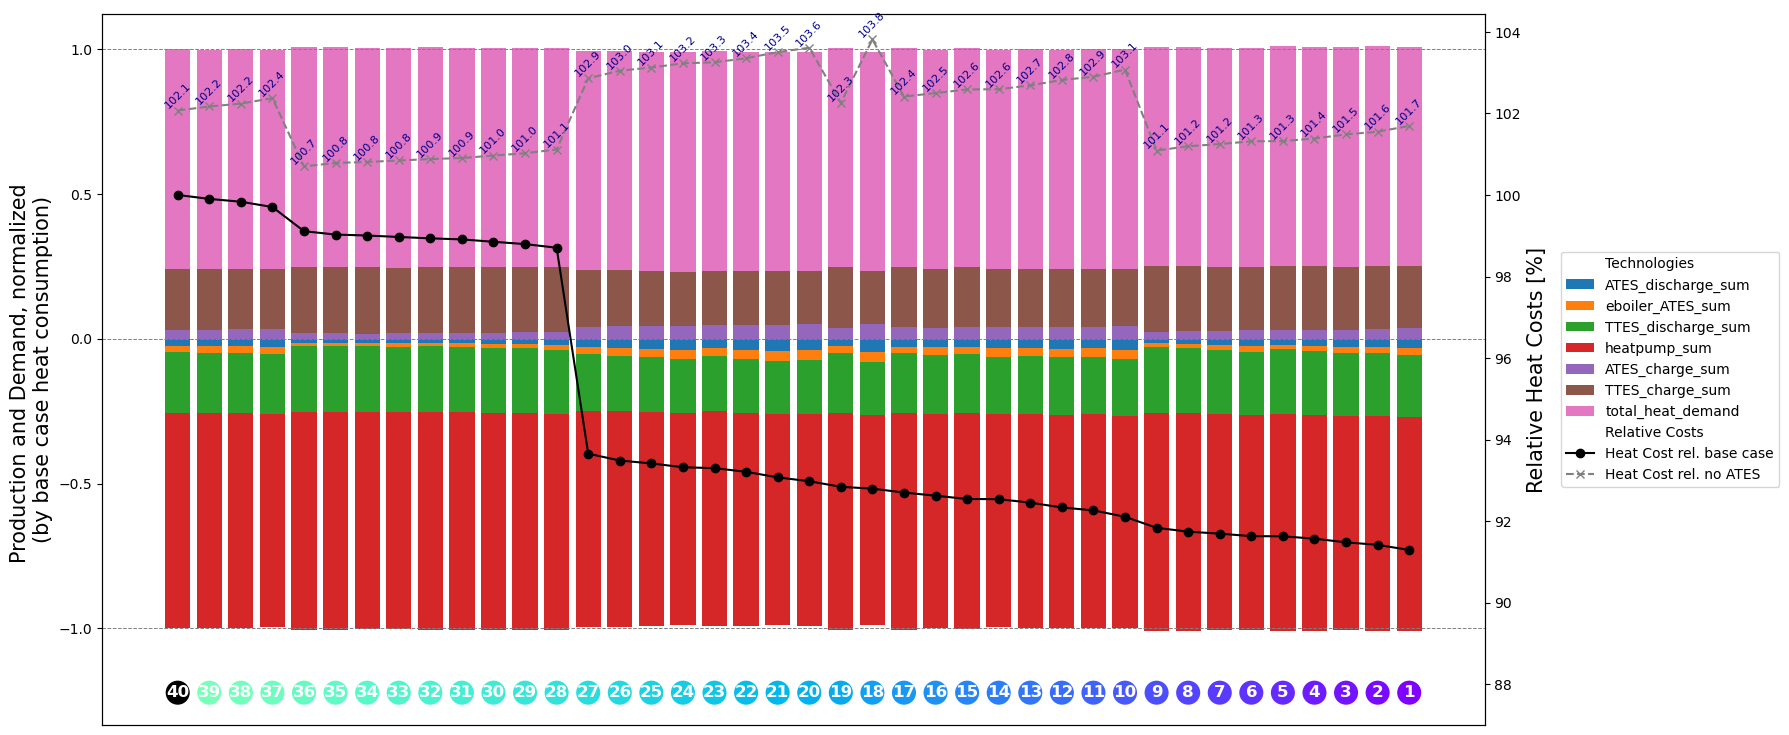

In [14]:

# Assume lower_costs_df is already defined
entries_lc = lower_costs_df.copy()
num_entries = len(entries_lc)

negative_cols = [
    'ATES_discharge_sum', 'eboiler_ATES_sum', 'heatpump_ATES_sum',
    'TTES_discharge_sum', 'eboiler_sum', 'heatpump_sum'
]
positive_cols = ['ATES_charge_sum', 'TTES_charge_sum', 'total_heat_demand']
tech_cols = negative_cols + positive_cols
tech_matrix = entries_lc[tech_cols].values

# Normalize by base case heat demand
demand_norm = np.abs(tech_matrix[0, :len(negative_cols)]).sum()
normalized_neg = -tech_matrix[:, :len(negative_cols)] / demand_norm
normalized_pos = tech_matrix[:, len(negative_cols):] / demand_norm

fig, ax = plt.subplots(figsize=(18, 7.5))
x_pos = np.arange(num_entries)

# --- stacked negative bars ---
bottom_neg = np.zeros(num_entries)
for i, col in enumerate(negative_cols):
    if not np.allclose(normalized_neg[:, i], 0):
        ax.bar(x_pos, normalized_neg[:, i], bottom=bottom_neg, label=col)
    bottom_neg += normalized_neg[:, i]

# --- stacked positive bars ---
bottom_pos = np.zeros(num_entries)
for i, col in enumerate(positive_cols):
    if not np.allclose(normalized_pos[:, i], 0):
        ax.bar(x_pos, normalized_pos[:, i], bottom=bottom_pos, label=col)
    bottom_pos += normalized_pos[:, i]

# Reference lines
ax.axhline(1, color='gray', linewidth=0.7, linestyle='--')
ax.axhline(0, color='gray', linewidth=0.7, linestyle='--')
ax.axhline(-1, color='gray', linewidth=0.7, linestyle='--')
ax.set_ylabel('Production and Demand, normalized \n(by base case heat consumption)', fontsize=15)

# --- secondary axis: relative costs ---
noATES_folder = "optimization_2_results_noATES"
normalized_noATES_lc = pd.Series(dtype=float, index=entries_lc['name'])
for fname in entries_lc['name']:
    noATES_fname = "noATES_" + fname
    noATES_path = os.path.join(noATES_folder, noATES_fname)
    if os.path.exists(noATES_path):
        noATES_df = pd.read_csv(noATES_path)
        noATES_cost = noATES_df['costs_per_MWh_demand'].iloc[0]
        normalized_noATES_lc[fname] = 100 * noATES_cost / entries_lc.loc[
            entries_lc['name'] == fname, 'costs_per_MWh_demand'
        ].iloc[0]
    else:
        normalized_noATES_lc[fname] = np.nan

ax2 = ax.twinx()
base_cost = entries_lc['costs_per_MWh_demand'].iloc[0]
relative_costs = 100 * entries_lc['costs_per_MWh_demand'] / base_cost

line1, = ax2.plot(
    x_pos, relative_costs,
    color='black', marker='o', linestyle='-', label='Heat Cost rel. base case'
)
line2, = ax2.plot(
    x_pos, normalized_noATES_lc.values,
    color='grey', marker='x', linestyle='--', label='Heat Cost rel. no ATES'
)
ax2.set_ylabel('Relative Heat Costs [%]', fontsize=15)
ax2.set_ylim(bottom=87)  # fixed lower limit

# Annotate the "noATES" values
for i, val in enumerate(normalized_noATES_lc):
    if not np.isnan(val):
        ax2.text(
            x_pos[i], val, f"{val:.1f}",
            color='darkblue', fontsize=8,
            ha='center', va='bottom', rotation=45
        )

# --- replace xticklabels with colored dots ---
ax.set_xticks([])  # hide old labels

# rainbow colormap restricted to half spectrum (greenish → purple)
rainbow_cmap = plt.colormaps['rainbow']
colors = [rainbow_cmap(i) for i in np.linspace(0.5, 0.0, num_entries)]  # flipped

# place circles below axis
ymin, ymax = ax.get_ylim()
y_label_level = ymin - 0.05 * (ymax - ymin)

for i in range(num_entries):
    # reversed numbering: last entry is 1
    num_label = num_entries - i
    # color: first entry black, others from half rainbow
    color = "black" if i == 0 else colors[i]
    ax.scatter(
        i, y_label_level, s=300,  # smaller circle
        color=color, edgecolors='none', zorder=5
    )
    ax.text(
        i, y_label_level, str(num_label),
        color="white", fontsize=12,  # bigger font
        ha="center", va="center", weight="bold", zorder=6
    )

# --- combined legend with headings ---
handles_tech, labels_tech = ax.get_legend_handles_labels()
handles_cost, labels_cost = ax2.get_legend_handles_labels()

# Dummy entries for headings (empty but visible text)
dummy_tech = Line2D([], [], color="none", label="Technologies")
dummy_cost = Line2D([], [], color="none", label="Relative Costs")

legend_handles = [dummy_tech] + handles_tech + [dummy_cost] + handles_cost
legend_labels = ["Technologies"] + labels_tech + ["Relative Costs"] + labels_cost

ax2.legend(
    legend_handles, legend_labels,
    loc='center left', bbox_to_anchor=(1.05, 0.5),
    fontsize=10, frameon=True
)

plt.tight_layout()
os.makedirs("RESULTS_PDFs", exist_ok=True)
plt.savefig(
    os.path.join("RESULTS_PDFs", "Bar Diagram of cheaper cases with relative costs.pdf"),
    bbox_inches='tight'
)
plt.show()

In [15]:
noATES_df['costs_per_MWh_demand'] / entries_lc['costs_per_MWh_demand']



0       1.011944
1       1.001473
2       0.993061
3       1.010903
4       0.999955
          ...   
8755         NaN
8756         NaN
8757         NaN
8758         NaN
8759         NaN
Name: costs_per_MWh_demand, Length: 8760, dtype: float64

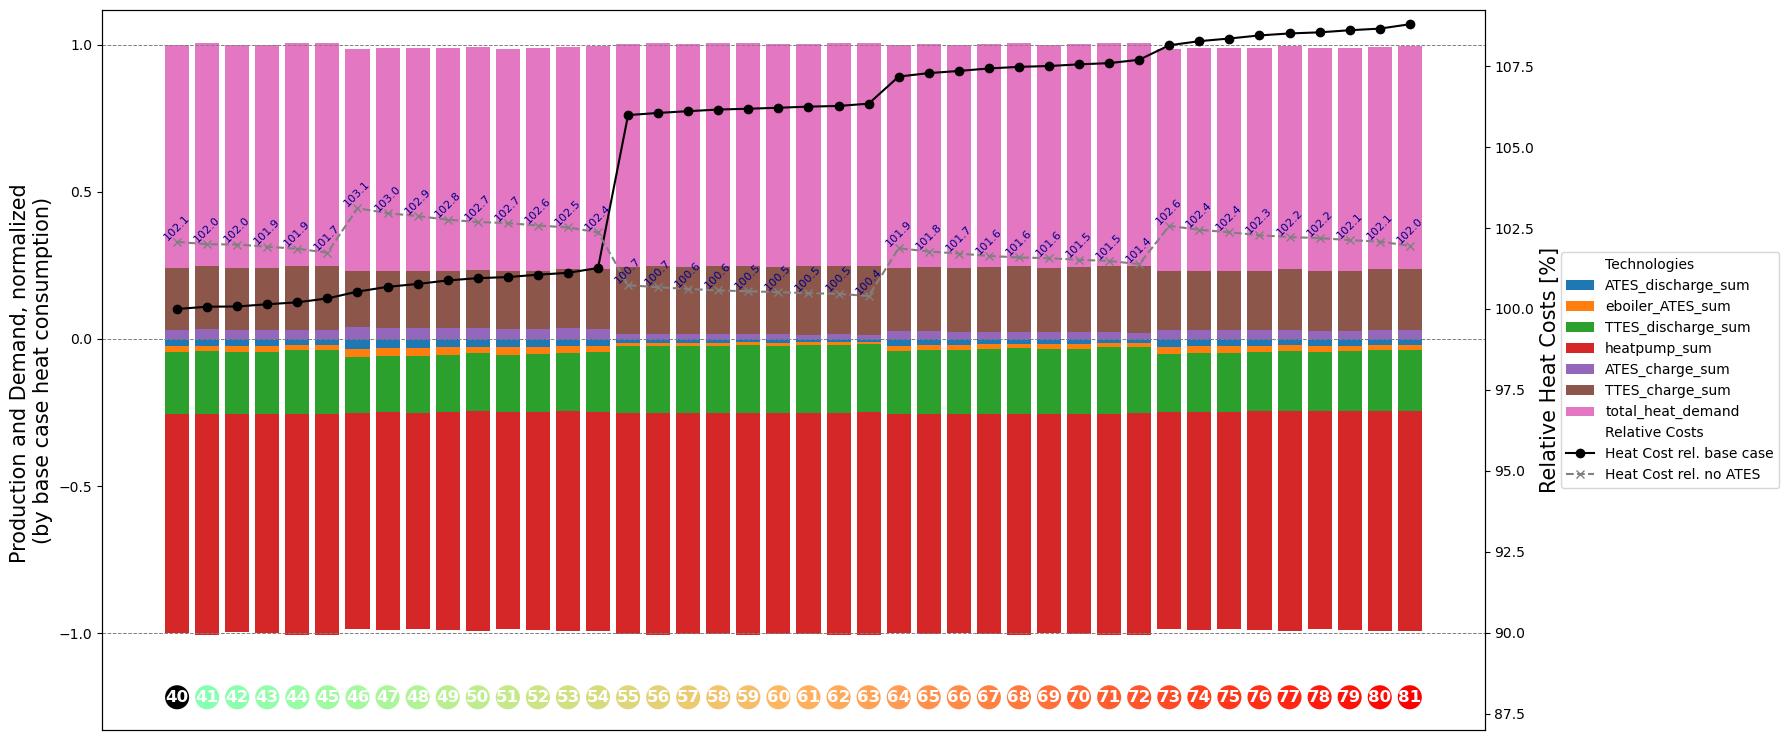

In [16]:
# --- More expensive cases plot (higher_costs_df) ---

entries_hc = higher_costs_df.copy()
num_entries = len(entries_hc)

negative_cols = ['ATES_discharge_sum',
                 'eboiler_ATES_sum', 'heatpump_ATES_sum', 'TTES_discharge_sum',
                 'eboiler_sum', 'heatpump_sum']
positive_cols = ['ATES_charge_sum', 'TTES_charge_sum', 'total_heat_demand']
tech_cols = negative_cols + positive_cols
tech_matrix = entries_hc[tech_cols].values

# normalize by base case heat demand
demand_norm = np.abs(tech_matrix[0, :len(negative_cols)]).sum()
normalized_neg = -tech_matrix[:, :len(negative_cols)] / demand_norm
normalized_pos = tech_matrix[:, len(negative_cols):] / demand_norm

fig, ax = plt.subplots(figsize=(18, 7.5))
x_pos = np.arange(num_entries)

# --- stacked bars ---
bottom_neg = np.zeros(num_entries)
for i, col in enumerate(negative_cols):
    if not np.allclose(normalized_neg[:, i], 0):
        ax.bar(x_pos, normalized_neg[:, i], bottom=bottom_neg, label=col)
    bottom_neg += normalized_neg[:, i]

bottom_pos = np.zeros(num_entries)
for i, col in enumerate(positive_cols):
    if not np.allclose(normalized_pos[:, i], 0):
        ax.bar(x_pos, normalized_pos[:, i], bottom=bottom_pos, label=col)
    bottom_pos += normalized_pos[:, i]

# reference lines
ax.axhline(1, color='gray', linewidth=0.7, linestyle='--')
ax.axhline(0, color='gray', linewidth=0.7, linestyle='--')
ax.axhline(-1, color='gray', linewidth=0.7, linestyle='--')

ax.set_ylabel('Production and Demand, normalized \n(by base case heat consumption)', fontsize=15)

# --- secondary axis: relative costs ---
noATES_folder = "optimization_2_results_noATES"
normalized_noATES_hc = pd.Series(dtype=float, index=entries_hc['name'])
for fname in entries_hc['name']:
    noATES_fname = "noATES_" + fname
    noATES_path = os.path.join(noATES_folder, noATES_fname)
    if os.path.exists(noATES_path):
        noATES_df = pd.read_csv(noATES_path)
        noATES_cost = noATES_df['costs_per_MWh_demand'].iloc[0]
        normalized_noATES_hc[fname] = 100 * noATES_cost / entries_hc.loc[
            entries_hc['name'] == fname, 'costs_per_MWh_demand'
        ].iloc[0]
    else:
        normalized_noATES_hc[fname] = np.nan

ax2 = ax.twinx()
base_cost = entries_hc['costs_per_MWh_demand'].iloc[0]
relative_costs = 100 * entries_hc['costs_per_MWh_demand'] / base_cost

line1, = ax2.plot(x_pos, relative_costs, color='black', marker='o',
                  linestyle='-', label='Heat Cost rel. base case')
line2, = ax2.plot(x_pos, normalized_noATES_hc.values, color='grey',
                  marker='x', linestyle='--', label='Heat Cost rel. no ATES')

ax2.set_ylabel('Relative Heat Costs [%]', fontsize=15)
ax2.set_ylim(bottom=87)

# annotate noATES values
for i, val in enumerate(normalized_noATES_hc):
    if not np.isnan(val):
        ax2.text(x_pos[i], val, f"{val:.1f}", color='darkblue',
                 fontsize=8, ha='center', va='bottom', rotation=45)

# --- replace xticklabels with colored dots ---
ax.set_xticks([])

# rainbow colormap restricted to second half (green → red)
rainbow_cmap = plt.colormaps['rainbow']
colors = [rainbow_cmap(i) for i in np.linspace(0.5, 1.0, num_entries)]

ymin, ymax = ax.get_ylim()
y_label_level = ymin - 0.05 * (ymax - ymin)

# numbering continues from len(entries_lc)+1 up to 81
start_num = len(entries_lc) 

for i in range(num_entries):
    num_label = start_num + i
    color = "black" if i == 0 else colors[i]
    ax.scatter(i, y_label_level, s=300,
               color=color, edgecolors='none', zorder=5)
    ax.text(i, y_label_level, str(num_label),
            color="white", fontsize=12,
            ha="center", va="center", weight="bold", zorder=6)

# --- combined legend with headings ---
handles_tech, labels_tech = ax.get_legend_handles_labels()
handles_cost, labels_cost = ax2.get_legend_handles_labels()

dummy_tech = Line2D([], [], color="none", label="Technologies")
dummy_cost = Line2D([], [], color="none", label="Relative Costs")

legend_handles = [dummy_tech] + handles_tech + [dummy_cost] + handles_cost
legend_labels = ["Technologies"] + labels_tech + ["Relative Costs"] + labels_cost

ax2.legend(legend_handles, legend_labels,
           loc='center left', bbox_to_anchor=(1.05, 0.5),
           fontsize=10, frameon=True)

plt.tight_layout()
plt.savefig(
    os.path.join("RESULTS_PDFs", "Bar Diagram of more expensive cases with relative costs.pdf"),
    bbox_inches='tight'
)
plt.show()


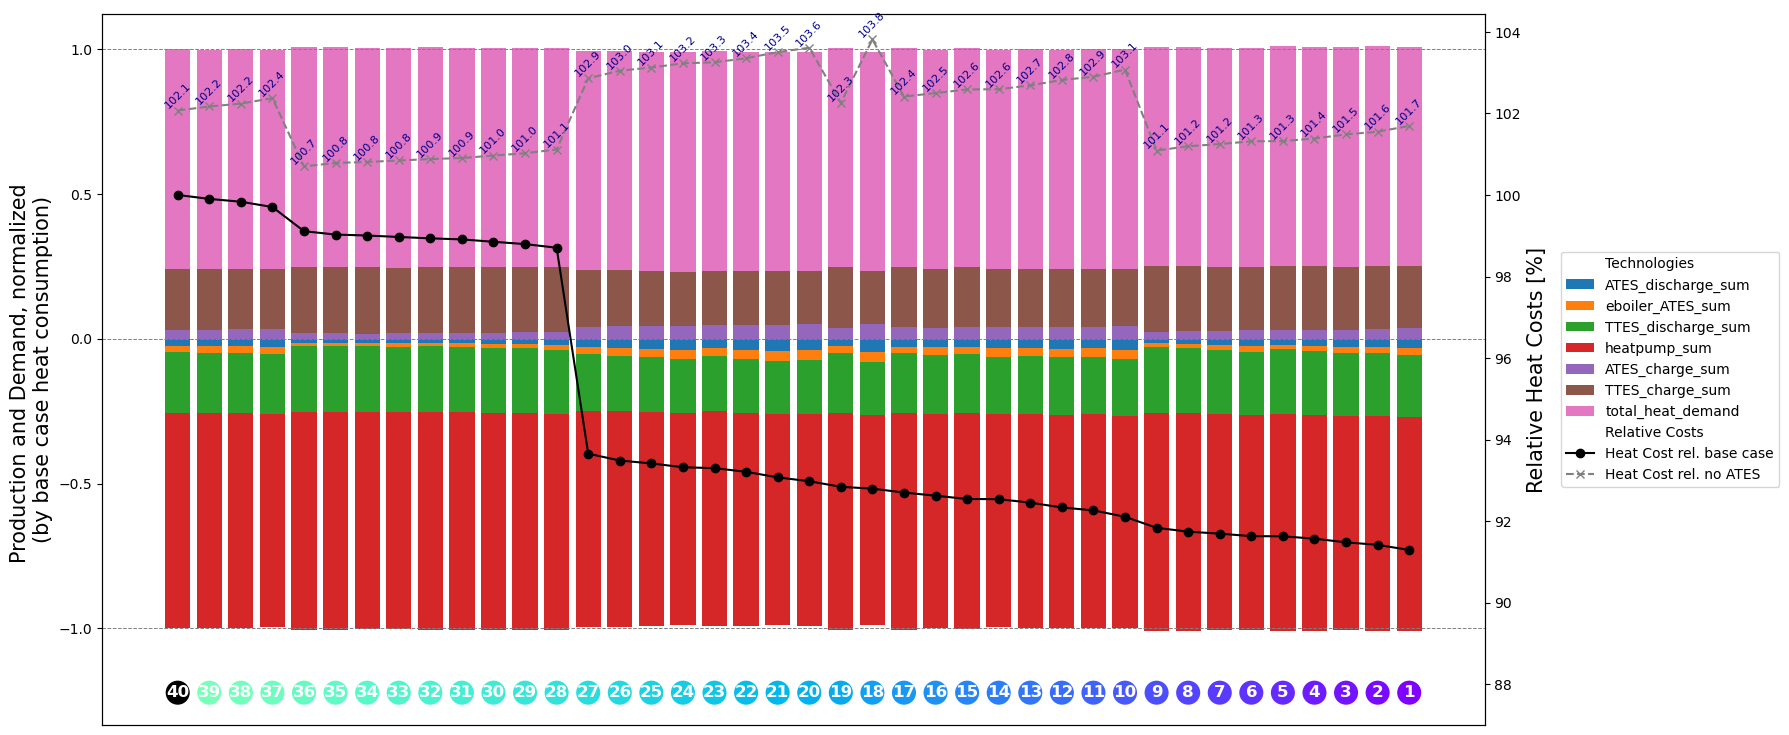

In [17]:

# Assume lower_costs_df is already defined
entries_lc = lower_costs_df.copy()
num_entries = len(entries_lc)

negative_cols = [
    'ATES_discharge_sum', 'eboiler_ATES_sum', 'heatpump_ATES_sum',
    'TTES_discharge_sum', 'eboiler_sum', 'heatpump_sum'
]
positive_cols = ['ATES_charge_sum', 'TTES_charge_sum', 'total_heat_demand']
tech_cols = negative_cols + positive_cols
tech_matrix = entries_lc[tech_cols].values

# Normalize by base case heat demand
demand_norm = np.abs(tech_matrix[0, :len(negative_cols)]).sum()
normalized_neg = -tech_matrix[:, :len(negative_cols)] / demand_norm
normalized_pos = tech_matrix[:, len(negative_cols):] / demand_norm

fig, ax = plt.subplots(figsize=(18, 7.5))
x_pos = np.arange(num_entries)

# --- stacked negative bars ---
bottom_neg = np.zeros(num_entries)
for i, col in enumerate(negative_cols):
    if not np.allclose(normalized_neg[:, i], 0):
        ax.bar(x_pos, normalized_neg[:, i], bottom=bottom_neg, label=col)
    bottom_neg += normalized_neg[:, i]

# --- stacked positive bars ---
bottom_pos = np.zeros(num_entries)
for i, col in enumerate(positive_cols):
    if not np.allclose(normalized_pos[:, i], 0):
        ax.bar(x_pos, normalized_pos[:, i], bottom=bottom_pos, label=col)
    bottom_pos += normalized_pos[:, i]

# Reference lines
ax.axhline(1, color='gray', linewidth=0.7, linestyle='--')
ax.axhline(0, color='gray', linewidth=0.7, linestyle='--')
ax.axhline(-1, color='gray', linewidth=0.7, linestyle='--')
ax.set_ylabel('Production and Demand, normalized \n(by base case heat consumption)', fontsize=15)

# # --- secondary axis: relative costs ---
# noATES_folder = "optimization_2_results_noATES"
# normalized_noATES_lc = pd.Series(dtype=float, index=entries_lc['name'])
# for fname in entries_lc['name']:
#     noATES_fname = "noATES_" + fname
#     noATES_path = os.path.join(noATES_folder, noATES_fname)
#     if os.path.exists(noATES_path):
#         noATES_df = pd.read_csv(noATES_path)
#         noATES_cost = noATES_df['costs_per_MWh_demand'].iloc[0]
#         normalized_noATES_lc[fname] = 100 * noATES_cost /entries_lc.loc[
#             entries_lc['name'] == fname, 'costs_per_MWh_demand'
#         ].iloc[0]
#     else:
#         normalized_noATES_lc[fname] = np.nan

ax2 = ax.twinx()
base_cost = entries_lc['costs_per_MWh_demand'].iloc[0]
relative_costs = 100 * entries_lc['costs_per_MWh_demand'] / base_cost

line1, = ax2.plot(
    x_pos, relative_costs,
    color='black', marker='o', linestyle='-', label='Heat Cost rel. base case'
)
line2, = ax2.plot(
    x_pos, normalized_noATES_lc.values,
    color='grey', marker='x', linestyle='--', label='Heat Cost rel. no ATES'
)
ax2.set_ylabel('Relative Heat Costs [%]', fontsize=15)
ax2.set_ylim(bottom=87)  # fixed lower limit

# Annotate the "noATES" values
for i, val in enumerate(normalized_noATES_lc):
    if not np.isnan(val):
        ax2.text(
            x_pos[i], val, f"{val:.1f}",
            color='darkblue', fontsize=8,
            ha='center', va='bottom', rotation=45
        )

# --- replace xticklabels with colored dots ---
ax.set_xticks([])  # hide old labels

# rainbow colormap restricted to half spectrum (greenish → purple)
rainbow_cmap = plt.colormaps['rainbow']
colors = [rainbow_cmap(i) for i in np.linspace(0.5, 0.0, num_entries)]  # flipped

# place circles below axis
ymin, ymax = ax.get_ylim()
y_label_level = ymin - 0.05 * (ymax - ymin)

for i in range(num_entries):
    # reversed numbering: last entry is 1
    num_label = num_entries - i
    # color: first entry black, others from half rainbow
    color = "black" if i == 0 else colors[i]
    ax.scatter(
        i, y_label_level, s=300,  # smaller circle
        color=color, edgecolors='none', zorder=5
    )
    ax.text(
        i, y_label_level, str(num_label),
        color="white", fontsize=12,  # bigger font
        ha="center", va="center", weight="bold", zorder=6
    )

# --- combined legend with headings ---
handles_tech, labels_tech = ax.get_legend_handles_labels()
handles_cost, labels_cost = ax2.get_legend_handles_labels()

# Dummy entries for headings (empty but visible text)
dummy_tech = Line2D([], [], color="none", label="Technologies")
dummy_cost = Line2D([], [], color="none", label="Relative Costs")

legend_handles = [dummy_tech] + handles_tech + [dummy_cost] + handles_cost
legend_labels = ["Technologies"] + labels_tech + ["Relative Costs"] + labels_cost

ax2.legend(
    legend_handles, legend_labels,
    loc='center left', bbox_to_anchor=(1.05, 0.5),
    fontsize=10, frameon=True
)

plt.tight_layout()
os.makedirs("RESULTS_PDFs", exist_ok=True)
plt.savefig(
    os.path.join("RESULTS_PDFs", "Bar Diagram of cheaper cases with relative costs.pdf"),
    bbox_inches='tight'
)
plt.show()


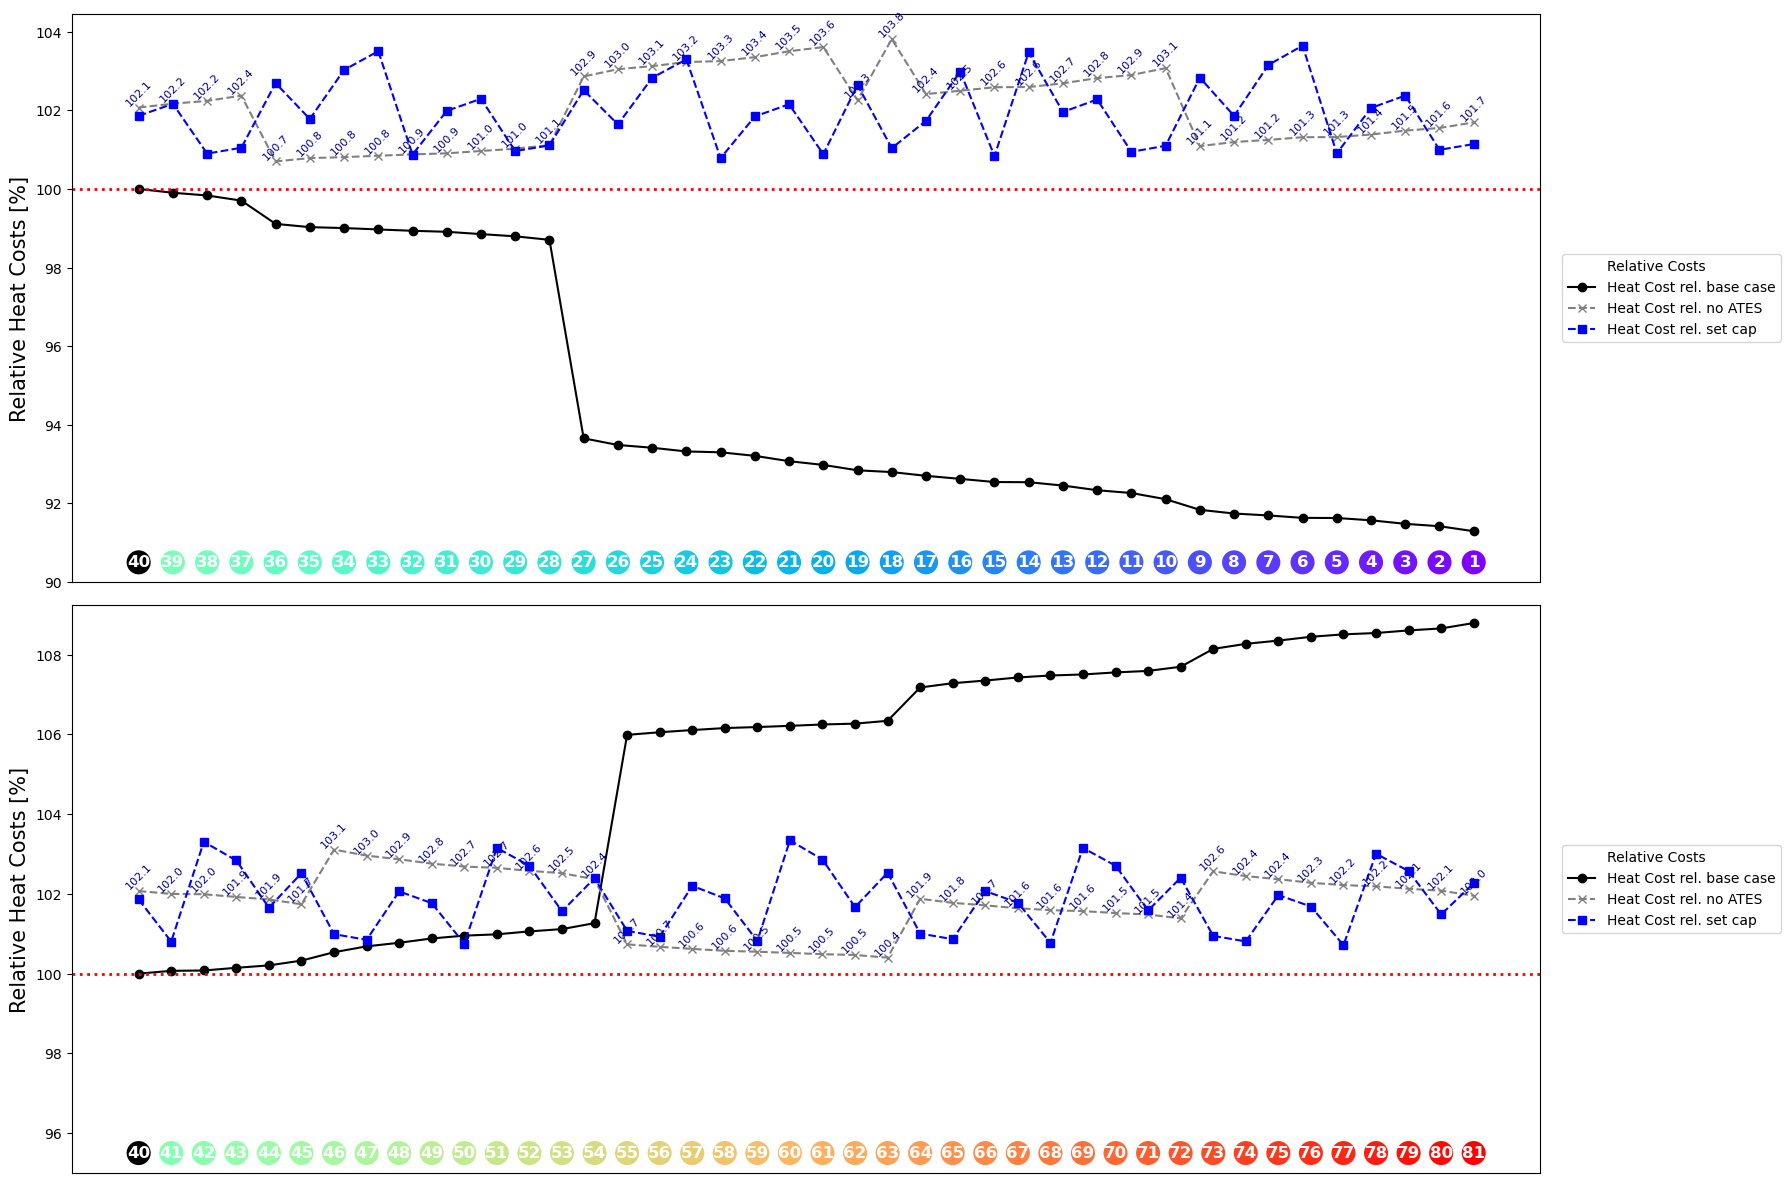

In [18]:
setcap_folder = "optimization_2_results_capmax"
normalized_setcap_lc = pd.Series(dtype=float, index=entries_lc['name'])

for fname in entries_lc['name']:
    setcap = os.path.join(setcap_folder, fname)
    if os.path.exists(setcap):
        setcap_df = pd.read_csv(setcap)
        normalized_setcap_lc[fname] = 100 * setcap_df['costs_per_MWh_demand'].iloc[0] / entries_lc.loc[entries_lc['name'] == fname, 'costs_per_MWh_demand'].iloc[0]
    else:
        normalized_setcap_lc[fname] = np.nan

normalized_setcap_hc = pd.Series(dtype=float, index=entries_hc['name'])
for fname in entries_hc['name']:
    setcap = os.path.join(setcap_folder, fname)
    if os.path.exists(setcap):
        setcap_df = pd.read_csv(setcap)
        setcap_cost = setcap_df['costs_per_MWh_demand'].iloc[0]
        normalized_setcap_hc[fname] = 100 * setcap_cost / entries_hc.loc[
            entries_hc['name'] == fname, 'costs_per_MWh_demand'
        ].iloc[0]
    else:
        normalized_setcap_hc[fname] = np.nan



fig, (ax_lc, ax_hc) = plt.subplots(2, 1, figsize=(18, 12), sharex=False)

# --- Cheaper cases: relative costs only ---
base_cost_lc = entries_lc['costs_per_MWh_demand'].iloc[0]
relative_costs_lc = 100 * entries_lc['costs_per_MWh_demand'] / base_cost_lc

line1_lc, = ax_lc.plot(
    x_pos, relative_costs_lc,
    color='black', marker='o', linestyle='-', label='Heat Cost rel. base case')
line2_lc, = ax_lc.plot(
    x_pos, normalized_noATES_lc.values,
    color='grey', marker='x', linestyle='--', label='Heat Cost rel. no ATES')
line3_lc, = ax_lc.plot(
    x_pos, normalized_setcap_lc.values,
    color='blue', marker='s', linestyle='--', label='Heat Cost rel. set cap')
ax_lc.set_ylabel('Relative Heat Costs [%]', fontsize=15)
ax_lc.set_ylim(bottom=90)
ax_lc.axhline(100, color='red', linestyle=':', linewidth=2)

for i, val in enumerate(normalized_noATES_lc):
    if not np.isnan(val):
        ax_lc.text(
            x_pos[i], val, f"{val:.1f}",
            color='darkblue', fontsize=8,
            ha='center', va='bottom', rotation=45
        )

# --- Cheaper cases: colored dots as x-axis ---
ax_lc.set_xticks([])
rainbow_cmap = plt.colormaps['rainbow']
colors_lc = [rainbow_cmap(i) for i in np.linspace(0.5, 0.0, num_entries)]
ymin_lc, ymax_lc = ax_lc.get_ylim()
# Place dots just above the lower line (ymin_lc + offset)
dot_level_lc = ymin_lc + 0.5  # adjust offset as needed
for i in range(num_entries):
    num_label = num_entries - i
    color = "black" if i == 0 else colors_lc[i]
    ax_lc.scatter(i, dot_level_lc, s=300, color=color, edgecolors='none', zorder=5)
    ax_lc.text(i, dot_level_lc, str(num_label), color="white", fontsize=12, ha="center", va="center", weight="bold", zorder=6)

# --- More expensive cases: relative costs only ---
num_entries_hc = len(entries_hc)
x_pos_hc = np.arange(num_entries_hc)
base_cost_hc = entries_hc['costs_per_MWh_demand'].iloc[0]
relative_costs_hc = 100 * entries_hc['costs_per_MWh_demand'] / base_cost_hc

line1_hc, = ax_hc.plot(x_pos_hc, relative_costs_hc, color='black', marker='o', linestyle='-', label='Heat Cost rel. base case')
line2_hc, = ax_hc.plot(x_pos_hc, normalized_noATES_hc.values, color='grey', marker='x', linestyle='--', label='Heat Cost rel. no ATES')
line3_hc, = ax_hc.plot(x_pos_hc, normalized_setcap_hc.values, color='blue', marker='s', linestyle='--', label='Heat Cost rel. set cap')
ax_hc.set_ylabel('Relative Heat Costs [%]', fontsize=15)
ax_hc.set_ylim(bottom=95)

for i, val in enumerate(normalized_noATES_hc):
    if not np.isnan(val):
        ax_hc.text(x_pos_hc[i], val, f"{val:.1f}", color='darkblue', fontsize=8, ha='center', va='bottom', rotation=45)

# --- More expensive cases: colored dots as x-axis ---
ax_hc.set_xticks([])
colors_hc = [rainbow_cmap(i) for i in np.linspace(0.5, 1.0, num_entries_hc)]
ymin_hc, ymax_hc = ax_hc.get_ylim()
dot_level_hc = ymin_hc + 0.5  # adjust offset as needed
start_num_hc = len(entries_lc)
for i in range(num_entries_hc):
    num_label = start_num_hc + i
    color = "black" if i == 0 else colors_hc[i]
    ax_hc.scatter(i, dot_level_hc, s=300, color=color, edgecolors='none', zorder=5)
    ax_hc.text(i, dot_level_hc, str(num_label), color="white", fontsize=12, ha="center", va="center", weight="bold", zorder=6)

# --- Legends ---
handles_lc, labels_lc = ax_lc.get_legend_handles_labels()
dummy_cost_lc = Line2D([], [], color="none", label="Relative Costs")
legend_handles_lc = [dummy_cost_lc] + handles_lc
legend_labels_lc = ["Relative Costs"] + labels_lc
ax_lc.legend(legend_handles_lc, legend_labels_lc, loc='center left', bbox_to_anchor=(1.01, 0.5), fontsize=10, frameon=True)

handles_hc, labels_hc = ax_hc.get_legend_handles_labels()
dummy_cost_hc = Line2D([], [], color="none", label="Relative Costs")
legend_handles_hc = [dummy_cost_hc] + handles_hc
legend_labels_hc = ["Relative Costs"] + labels_hc
ax_hc.legend(legend_handles_hc, legend_labels_hc, loc='center left', bbox_to_anchor=(1.01, 0.5), fontsize=10, frameon=True)
ax_hc.axhline(100, color='red', linestyle=':', linewidth=2, label='100% Reference')
plt.tight_layout()
plt.savefig(
    os.path.join("RESULTS_PDFs", "Relative_costs_cheaper_and_expensive_cases.pdf"),
    bbox_inches='tight'
)
plt.show()


In [19]:
normalized_setcap_lc

name
phi_c_0.925253_elp_1.0_drc_1000.0_CapTT_3036.1.csv     101.860533
phi_c_0.941598_elp_1.0_drc_1000.0_CapTT_3036.1.csv     102.166579
phi_c_0.925253_elp_1.0_drc_500.0_CapTT_3036.1.csv      100.900059
phi_c_0.941598_elp_1.0_drc_500.0_CapTT_3036.1.csv      101.048069
phi_c_0.905008_elp_1.0_drc_1500.0_CapTT_1518.05.csv    102.693249
phi_c_0.905008_elp_1.0_drc_1000.0_CapTT_1518.05.csv    101.780253
phi_c_0.925253_elp_1.0_drc_1500.0_CapTT_1518.05.csv    103.027879
phi_c_0.941598_elp_1.0_drc_1500.0_CapTT_1518.05.csv    103.504915
phi_c_0.905008_elp_1.0_drc_500.0_CapTT_1518.05.csv     100.875612
phi_c_0.925253_elp_1.0_drc_1000.0_CapTT_1518.05.csv    101.986833
phi_c_0.941598_elp_1.0_drc_1000.0_CapTT_1518.05.csv    102.294375
phi_c_0.925253_elp_1.0_drc_500.0_CapTT_1518.05.csv     100.963987
phi_c_0.941598_elp_1.0_drc_500.0_CapTT_1518.05.csv     101.108768
phi_c_0.905008_elp_0.9_drc_1500.0_CapTT_6072.2.csv     102.515140
phi_c_0.905008_elp_0.9_drc_1000.0_CapTT_6072.2.csv     101.641714
phi_c

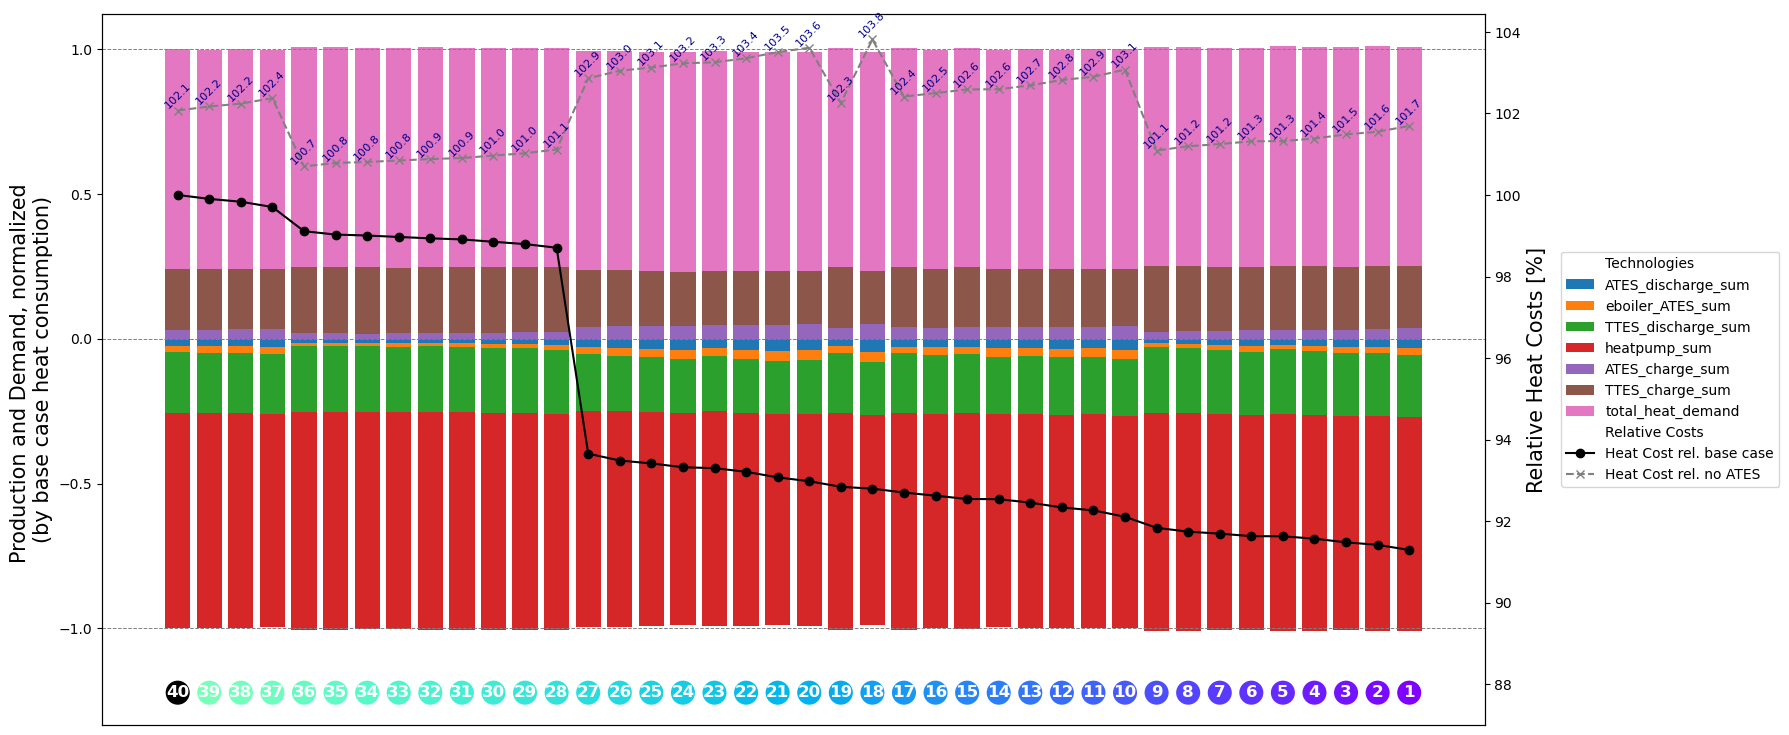

In [20]:

# Assume lower_costs_df is already defined
entries_lc = lower_costs_df.copy()
num_entries = len(entries_lc)

negative_cols = [
    'ATES_discharge_sum', 'eboiler_ATES_sum', 'heatpump_ATES_sum',
    'TTES_discharge_sum', 'eboiler_sum', 'heatpump_sum'
]
positive_cols = ['ATES_charge_sum', 'TTES_charge_sum', 'total_heat_demand']
tech_cols = negative_cols + positive_cols
tech_matrix = entries_lc[tech_cols].values

# Normalize by base case heat demand
demand_norm = np.abs(tech_matrix[0, :len(negative_cols)]).sum()
normalized_neg = -tech_matrix[:, :len(negative_cols)] / demand_norm
normalized_pos = tech_matrix[:, len(negative_cols):] / demand_norm

fig, ax = plt.subplots(figsize=(18, 7.5))
x_pos = np.arange(num_entries)

# --- stacked negative bars ---
bottom_neg = np.zeros(num_entries)
for i, col in enumerate(negative_cols):
    if not np.allclose(normalized_neg[:, i], 0):
        ax.bar(x_pos, normalized_neg[:, i], bottom=bottom_neg, label=col)
    bottom_neg += normalized_neg[:, i]

# --- stacked positive bars ---
bottom_pos = np.zeros(num_entries)
for i, col in enumerate(positive_cols):
    if not np.allclose(normalized_pos[:, i], 0):
        ax.bar(x_pos, normalized_pos[:, i], bottom=bottom_pos, label=col)
    bottom_pos += normalized_pos[:, i]

# Reference lines
ax.axhline(1, color='gray', linewidth=0.7, linestyle='--')
ax.axhline(0, color='gray', linewidth=0.7, linestyle='--')
ax.axhline(-1, color='gray', linewidth=0.7, linestyle='--')
ax.set_ylabel('Production and Demand, normalized \n(by base case heat consumption)', fontsize=15)

# --- secondary axis: relative costs ---
# noATES_folder = "optimization_2_results_noATES"
# normalized_noATES_lc = pd.Series(dtype=float, index=entries_lc['name'])
# for fname in entries_lc['name']:
#     noATES_fname = "noATES_" + fname
#     noATES_path = os.path.join(noATES_folder, noATES_fname)
#     if os.path.exists(noATES_path):
#         noATES_df = pd.read_csv(noATES_path)
#         noATES_cost = noATES_df['costs_per_MWh_demand'].iloc[0]
#         normalized_noATES_lc[fname] = 100 * entries_lc.loc[
#             entries_lc['name'] == fname, 'costs_per_MWh_demand'
#         ].iloc[0] / noATES_cost
#     else:
#         normalized_noATES_lc[fname] = np.nan

ax2 = ax.twinx()
base_cost = entries_lc['costs_per_MWh_demand'].iloc[0]
relative_costs = 100 * entries_lc['costs_per_MWh_demand'] / base_cost

line1, = ax2.plot(
    x_pos, relative_costs,
    color='black', marker='o', linestyle='-', label='Heat Cost rel. base case'
)
line2, = ax2.plot(
    x_pos, normalized_noATES_lc.values,
    color='grey', marker='x', linestyle='--', label='Heat Cost rel. no ATES'
)
ax2.set_ylabel('Relative Heat Costs [%]', fontsize=15)
ax2.set_ylim(bottom=87)  # fixed lower limit

# Annotate the "noATES" values
for i, val in enumerate(normalized_noATES_lc):
    if not np.isnan(val):
        ax2.text(
            x_pos[i], val, f"{val:.1f}",
            color='darkblue', fontsize=8,
            ha='center', va='bottom', rotation=45
        )

# --- replace xticklabels with colored dots ---
ax.set_xticks([])  # hide old labels

# rainbow colormap restricted to half spectrum (greenish → purple)
rainbow_cmap = plt.colormaps['rainbow']
colors = [rainbow_cmap(i) for i in np.linspace(0.5, 0.0, num_entries)]  # flipped

# place circles below axis
ymin, ymax = ax.get_ylim()
y_label_level = ymin - 0.05 * (ymax - ymin)

for i in range(num_entries):
    # reversed numbering: last entry is 1
    num_label = num_entries - i
    # color: first entry black, others from half rainbow
    color = "black" if i == 0 else colors[i]
    ax.scatter(
        i, y_label_level, s=300,  # smaller circle
        color=color, edgecolors='none', zorder=5
    )
    ax.text(
        i, y_label_level, str(num_label),
        color="white", fontsize=12,  # bigger font
        ha="center", va="center", weight="bold", zorder=6
    )

# --- combined legend with headings ---
handles_tech, labels_tech = ax.get_legend_handles_labels()
handles_cost, labels_cost = ax2.get_legend_handles_labels()

# Dummy entries for headings (empty but visible text)
dummy_tech = Line2D([], [], color="none", label="Technologies")
dummy_cost = Line2D([], [], color="none", label="Relative Costs")

legend_handles = [dummy_tech] + handles_tech + [dummy_cost] + handles_cost
legend_labels = ["Technologies"] + labels_tech + ["Relative Costs"] + labels_cost

ax2.legend(
    legend_handles, legend_labels,
    loc='center left', bbox_to_anchor=(1.05, 0.5),
    fontsize=10, frameon=True
)

plt.tight_layout()
os.makedirs("RESULTS_PDFs", exist_ok=True)
plt.savefig(
    os.path.join("RESULTS_PDFs", "Bar Diagram of cheaper cases with relative costs.pdf"),
    bbox_inches='tight'
)
plt.show()


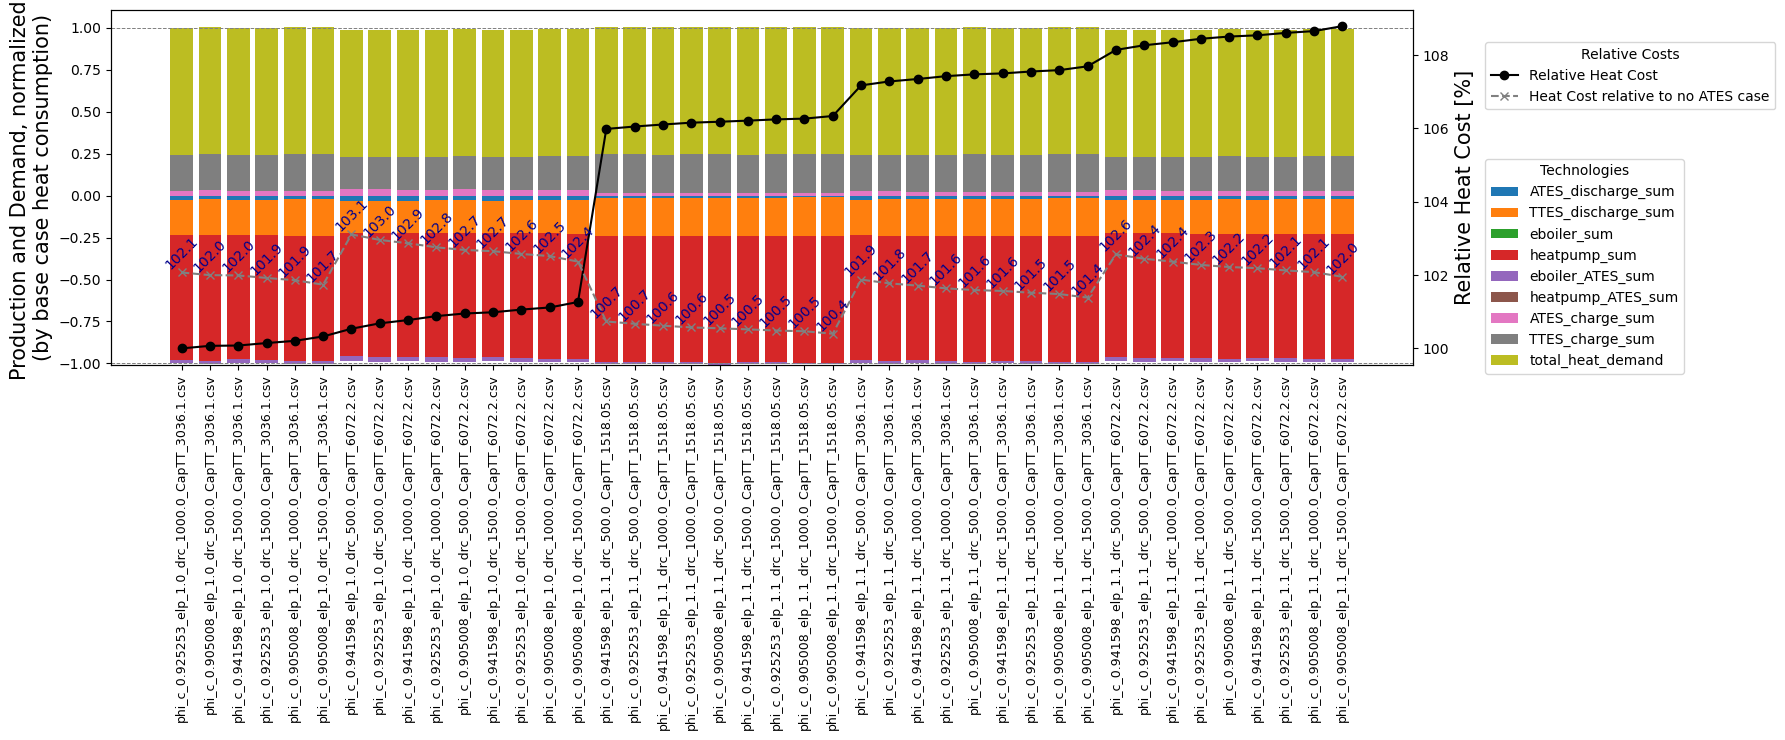

In [21]:
# First plot: all entries from higher_costs_df (up to available rows)
entries_hc = higher_costs_df.copy()
num_entries = len(entries_hc)
negative_cols = ['ATES_discharge_sum', 'TTES_discharge_sum', 'eboiler_sum', 'heatpump_sum', 'eboiler_ATES_sum', 'heatpump_ATES_sum']
positive_cols = ['ATES_charge_sum', 'TTES_charge_sum', 'total_heat_demand']
tech_cols = negative_cols + positive_cols
tech_matrix = entries_hc[tech_cols].values

demand_norm = np.abs(tech_matrix[0, :len(negative_cols)]).sum()
normalized_neg = -tech_matrix[:, :len(negative_cols)] / demand_norm
normalized_pos = tech_matrix[:, len(negative_cols):] / demand_norm

fig, ax = plt.subplots(figsize=(18, 7.5))
x_pos = np.arange(num_entries)

bottom_neg = np.zeros(num_entries)
for i, col in enumerate(negative_cols):
    ax.bar(x_pos, normalized_neg[:, i], bottom=bottom_neg, label=col)
    bottom_neg += normalized_neg[:, i]

bottom_pos = np.zeros(num_entries)
for i, col in enumerate(positive_cols):
    ax.bar(x_pos, normalized_pos[:, i], bottom=bottom_pos, label=col)
    bottom_pos += normalized_pos[:, i]

# Thin horizontal lines at y=1 and y=-1
ax.axhline(1, color='gray', linewidth=0.7, linestyle='--')
ax.axhline(-1, color='gray', linewidth=0.7, linestyle='--')

ax.set_xticks(x_pos)
ax.set_xticklabels(entries_hc['name'], rotation=90, fontsize=9)
ax.set_ylabel('Production and Demand, normalized \n(by base case heat consumption)', fontsize=15)
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=10)

# Add another plot to the secondary y-axis: normalized by noATES case
# noATES_folder = "optimization_2_results_noATES"
# normalized_noATES_hc = pd.Series(dtype=float, index=entries_hc['name'])
# for fname in entries_hc['name']:
#     noATES_fname = "noATES_" + fname
#     noATES_path = os.path.join(noATES_folder, noATES_fname)
#     if os.path.exists(noATES_path):
#         noATES_df = pd.read_csv(noATES_path)
#         noATES_cost = noATES_df['costs_per_MWh_demand'].iloc[0]
#         normalized_noATES_hc[fname] = 100 * entries_hc.loc[entries_hc['name'] == fname, 'costs_per_MWh_demand'].iloc[0] / noATES_cost
#     else:
#         normalized_noATES_hc[fname] = np.nan

ax.legend(loc='upper left', bbox_to_anchor=(1.05, 0.6), fontsize=10, title='Technologies')

# second y-axis
ax2 = ax.twinx()
base_cost = entries_hc['costs_per_MWh_demand'].iloc[0]
relative_costs = 100 * entries_hc['costs_per_MWh_demand'] / base_cost
ax2.plot(x_pos, relative_costs, color='black', marker='o', linestyle='-', label='Relative Heat Cost')
ax2.set_ylabel('Relative Heat Cost [%]', fontsize=15)
ax2.legend(loc='upper right', fontsize=10)

ax2.plot(x_pos, normalized_noATES_hc.values, color='grey', marker='x', linestyle='--', label='Heat Cost relative to no ATES case')
for i, val in enumerate(normalized_noATES_hc):
    if not np.isnan(val):
        ax2.text(x_pos[i], val, f"{val:.1f}", color='darkblue', fontsize=10, ha='center', va='bottom', rotation=45)



# Move both legends outside the plot, stacked vertically
ax2.legend(loc='lower left', bbox_to_anchor=(1.05, 0.7), fontsize=10, title='Relative Costs')
plt.tight_layout()
plt.savefig(os.path.join("RESULTS_PDFs", "Bar Diagram of more expensive cases with relative costs.pdf"), bbox_inches='tight')
plt.show()



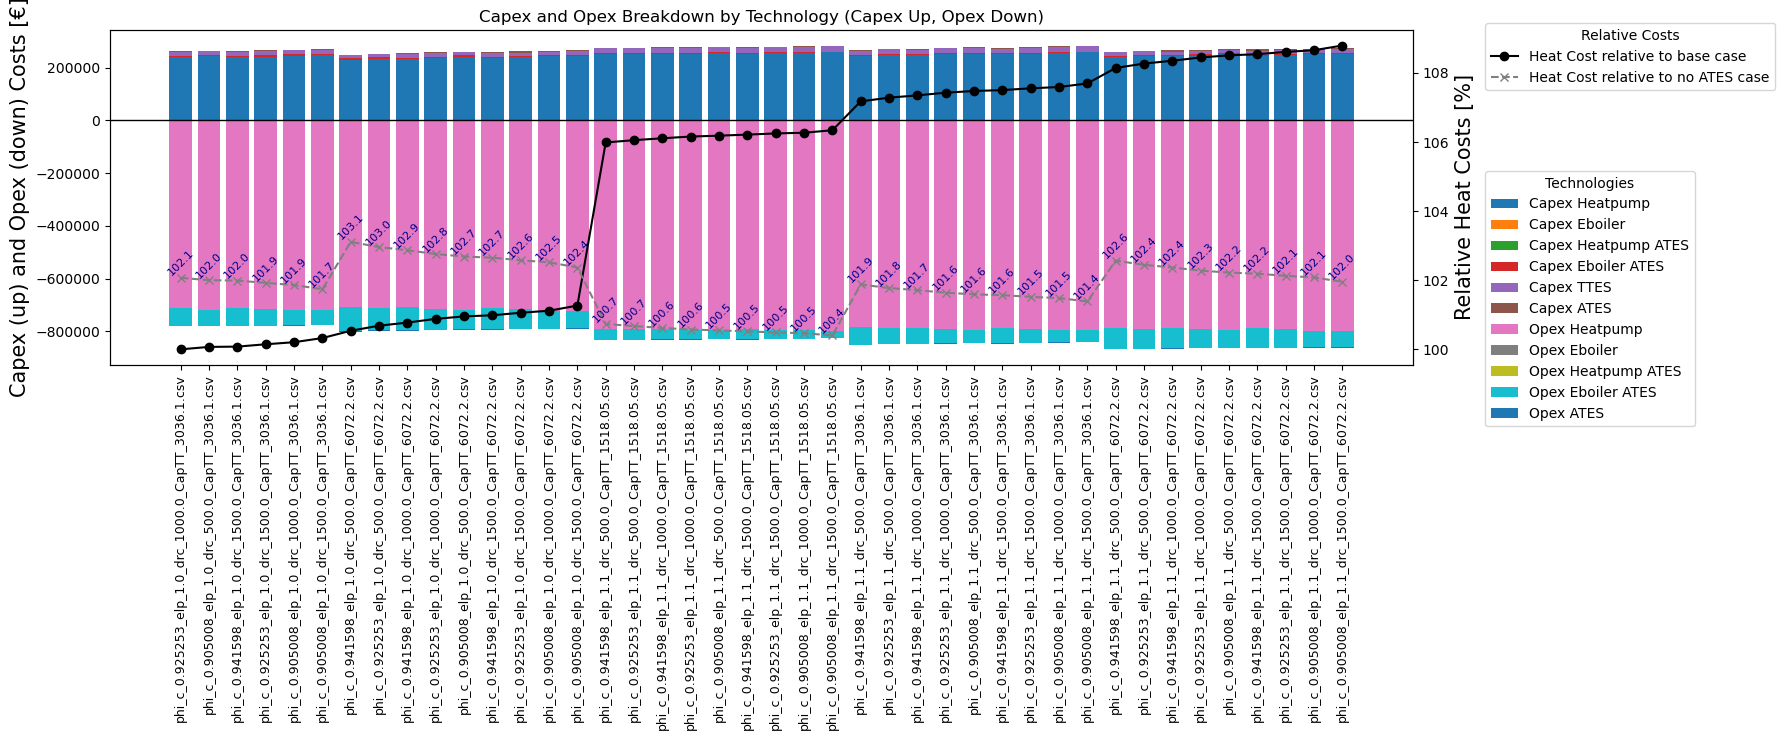

In [22]:
# Prepare lists to store calculated costs
#capex_heatpump,capex_eboiler,capex_hp_ATES,capex_eb_ATES,capex_ATES,capex_TTES,
#opex_heatpump,opex_eboiler,opex_hp_ATES,opex_eb_ATES,opex_ATES
capex_vals = []
opex_vals = []

for fname in entries_hc['name']:
    df_path = os.path.join(folder, fname)
    df = pd.read_csv(df_path)
    # Capex
    capex_heatpump = df['capex_heatpump'].iloc[0] if 'capex_heatpump' in df else 0
    capex_eboiler = df['capex_eboiler'].iloc[0] if 'capex_eboiler' in df else 0
    capex_heatpump_ATES = df['capex_hp_ATES'].iloc[0] if 'capex_hp_ATES' in df else 0
    capex_eboiler_ATES = df['capex_eb_ATES'].iloc[0] if 'capex_eb_ATES' in df else 0
    capex_TTES = df['capex_TTES'].iloc[0] if 'capex_TTES' in df else 0
    CAPEX_ATES = df['capex_ATES'].iloc[0] if 'capex_ATES' in df else 0


    # Opex
    opex_heatpump = (df['opex_heatpump']).iloc[0] if 'opex_heatpump' in df else 0
    opex_eboiler = (df['opex_eboiler']).iloc[0] if 'opex_eboiler' in df else 0
    opex_heatpump_ATES = (df['opex_hp_ATES']).iloc[0] if 'opex_hp_ATES' in df else 0
    opex_eboiler_ATES = (df['opex_eb_ATES']).iloc[0] if 'opex_eb_ATES' in df else 0
    OPEX_ATES = (df['opex_ATES']).iloc[0] if 'opex_ATES' in df else 0

    # Capex vector
    capex_vec = [
        capex_heatpump,
        capex_eboiler,
        capex_heatpump_ATES,
        capex_eboiler_ATES,
        capex_TTES,
        CAPEX_ATES
    ]
    # Opex vector
    opex_vec = [
        opex_heatpump,
        opex_eboiler,
        opex_heatpump_ATES,
        opex_eboiler_ATES,
        OPEX_ATES
    ]
    capex_vals.append(capex_vec)
    opex_vals.append(opex_vec)

capex_vals = np.array(capex_vals)
opex_vals = np.array(opex_vals)

capex_labels = ['Capex Heatpump', 'Capex Eboiler', 'Capex Heatpump ATES', 'Capex Eboiler ATES', 'Capex TTES', 'Capex ATES']
opex_labels = ['Opex Heatpump', 'Opex Eboiler', 'Opex Heatpump ATES', 'Opex Eboiler ATES', 'Opex ATES']

num_entries = len(entries_hc)
fig, ax = plt.subplots(figsize=(18, 7.5))
x_pos = np.arange(num_entries)

# Plot Capex bars upwards
bottom_capex = np.zeros(num_entries)
for i, label in enumerate(capex_labels):
    ax.bar(x_pos, capex_vals[:, i], bottom=bottom_capex, label=label)
    bottom_capex += capex_vals[:, i]

# Plot Opex bars downwards (negative direction)
bottom_opex = np.zeros(num_entries)
for i, label in enumerate(opex_labels):
    ax.bar(x_pos, -opex_vals[:, i], bottom=-bottom_opex, label=label)
    bottom_opex += opex_vals[:, i]

ax.set_xticks(x_pos)
ax.set_xticklabels(entries_hc['name'], rotation=90, fontsize=9)
ax.set_ylabel('Capex (up) and Opex (down) Costs [€]', fontsize=15)
ax.set_title('Capex and Opex Breakdown by Technology (Capex Up, Opex Down)')

ax.axhline(0, color='black', linewidth=1)
# Add secondary y-axis for relative costs_per_MWh_demand
ax2 = ax.twinx()
base_cost = entries_hc['costs_per_MWh_demand'].iloc[0]
relative_costs = 100 * entries_hc['costs_per_MWh_demand'] / base_cost
ax2.plot(x_pos, relative_costs, color='black', marker='o', linestyle='-', label='Heat Cost relative to base case')
ax2.set_ylabel('Relative Heat Costs [%]', fontsize=15)
ax2.legend(loc='upper right', fontsize='small')

ax2.plot(x_pos, normalized_noATES_hc.values, color='grey', marker='x', linestyle='--', label='Heat Cost relative to no ATES case')
for i, val in enumerate(normalized_noATES_hc):
    if not np.isnan(val):
        ax2.text(x_pos[i], val, f"{val:.1f}", color='darkblue', fontsize=8, ha='center', va='bottom', rotation=45)

# Move both legends outside the plot, stacked vertically
ax2.legend(loc='lower left', bbox_to_anchor=(1.05, 0.8), fontsize=10, title='Relative Costs')
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 0.6), fontsize=10, title='Technologies')

plt.tight_layout()

plt.savefig(os.path.join("RESULTS_PDFs", "Bar Diagram of more expensive cases Capex Opex.pdf"), bbox_inches='tight')
plt.show()



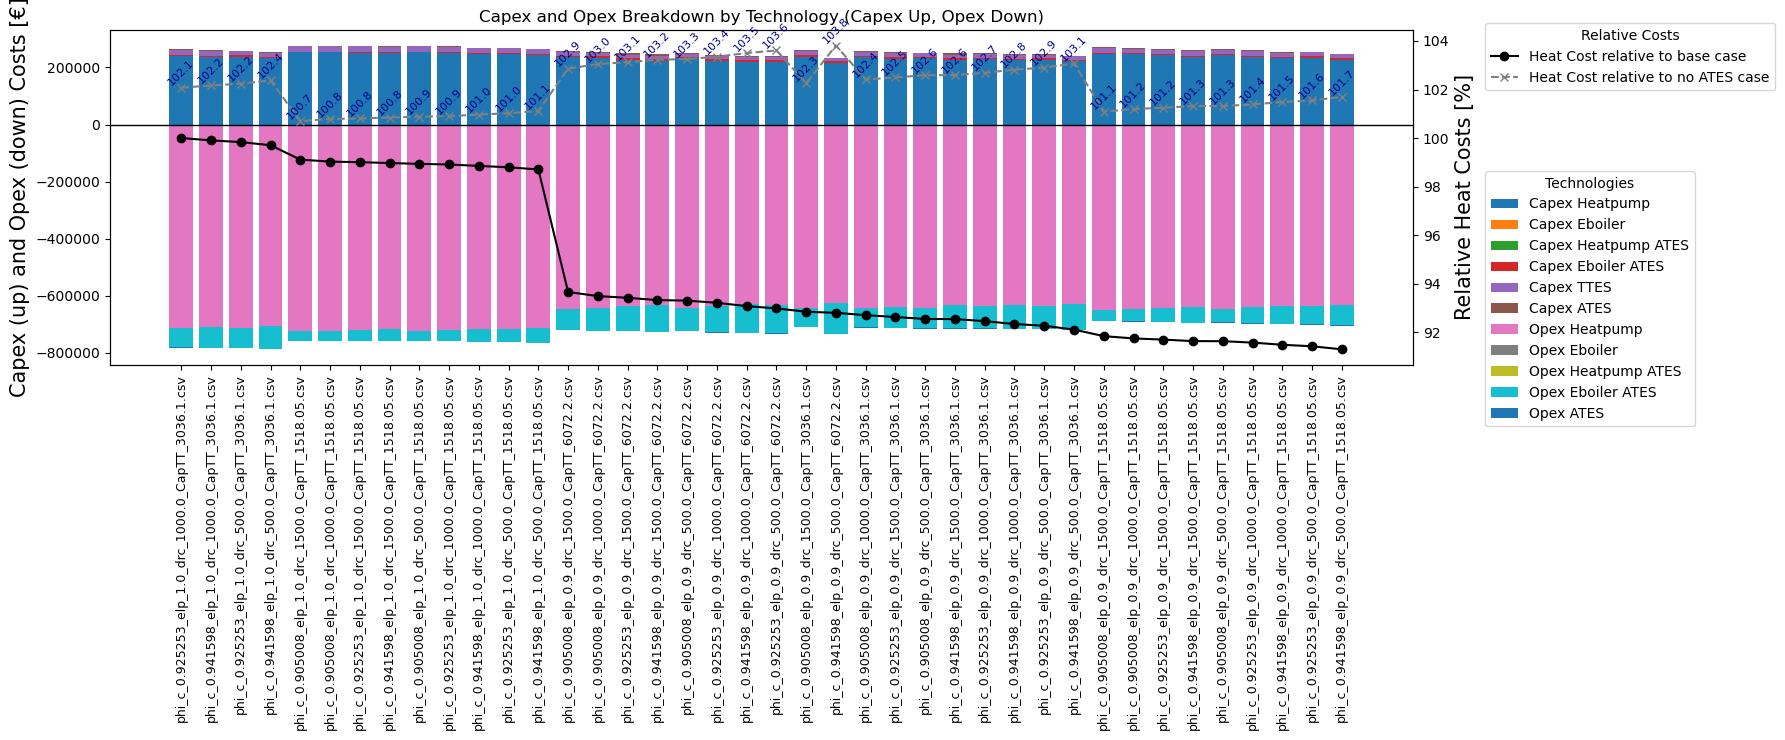

In [23]:
# Prepare lists to store calculated costs
#capex_heatpump,capex_eboiler,capex_hp_ATES,capex_eb_ATES,capex_ATES,capex_TTES,
#opex_heatpump,opex_eboiler,opex_hp_ATES,opex_eb_ATES,opex_ATES
capex_vals = []
opex_vals = []

for fname in entries_lc['name']:
    df_path = os.path.join(folder, fname)
    df = pd.read_csv(df_path)
    # Capex
    capex_heatpump = df['capex_heatpump'].iloc[0] if 'capex_heatpump' in df else 0
    capex_eboiler = df['capex_eboiler'].iloc[0] if 'capex_eboiler' in df else 0
    capex_heatpump_ATES = df['capex_hp_ATES'].iloc[0] if 'capex_hp_ATES' in df else 0
    capex_eboiler_ATES = df['capex_eb_ATES'].iloc[0] if 'capex_eb_ATES' in df else 0
    capex_TTES = df['capex_TTES'].iloc[0] if 'capex_TTES' in df else 0
    CAPEX_ATES = df['capex_ATES'].iloc[0] if 'capex_ATES' in df else 0


    # Opex
    opex_heatpump = (df['opex_heatpump']).iloc[0] if 'opex_heatpump' in df else 0
    opex_eboiler = (df['opex_eboiler']).iloc[0] if 'opex_eboiler' in df else 0
    opex_heatpump_ATES = (df['opex_hp_ATES']).iloc[0] if 'opex_hp_ATES' in df else 0
    opex_eboiler_ATES = (df['opex_eb_ATES']).iloc[0] if 'opex_eb_ATES' in df else 0
    OPEX_ATES = (df['opex_ATES']).iloc[0] if 'opex_ATES' in df else 0

    # Capex vector
    capex_vec = [
        capex_heatpump,
        capex_eboiler,
        capex_heatpump_ATES,
        capex_eboiler_ATES,
        capex_TTES,
        CAPEX_ATES
    ]
    # Opex vector
    opex_vec = [
        opex_heatpump,
        opex_eboiler,
        opex_heatpump_ATES,
        opex_eboiler_ATES,
        OPEX_ATES
    ]
    capex_vals.append(capex_vec)
    opex_vals.append(opex_vec)

capex_vals = np.array(capex_vals)
opex_vals = np.array(opex_vals)

capex_labels = ['Capex Heatpump', 'Capex Eboiler', 'Capex Heatpump ATES', 'Capex Eboiler ATES', 'Capex TTES', 'Capex ATES']
opex_labels = ['Opex Heatpump', 'Opex Eboiler', 'Opex Heatpump ATES', 'Opex Eboiler ATES', 'Opex ATES']

num_entries = len(entries_lc)
fig, ax = plt.subplots(figsize=(18, 7.5))
x_pos = np.arange(num_entries)

# Plot Capex bars upwards
bottom_capex = np.zeros(num_entries)
for i, label in enumerate(capex_labels):
    ax.bar(x_pos, capex_vals[:, i], bottom=bottom_capex, label=label)
    bottom_capex += capex_vals[:, i]

# Plot Opex bars downwards (negative direction)
bottom_opex = np.zeros(num_entries)
for i, label in enumerate(opex_labels):
    ax.bar(x_pos, -opex_vals[:, i], bottom=-bottom_opex, label=label)
    bottom_opex += opex_vals[:, i]

ax.set_xticks(x_pos)
ax.set_xticklabels(entries_lc['name'], rotation=90, fontsize=9)
ax.set_ylabel('Capex (up) and Opex (down) Costs [€]', fontsize=15)
ax.set_title('Capex and Opex Breakdown by Technology (Capex Up, Opex Down)')

ax.axhline(0, color='black', linewidth=1)
# Add secondary y-axis for relative costs_per_MWh_demand
ax2 = ax.twinx()
base_cost = entries_lc['costs_per_MWh_demand'].iloc[0]
relative_costs = 100 * entries_lc['costs_per_MWh_demand'] / base_cost
ax2.plot(x_pos, relative_costs, color='black', marker='o', linestyle='-', label='Heat Cost relative to base case')
ax2.set_ylabel('Relative Heat Costs [%]', fontsize=15)
ax2.legend(loc='upper right', fontsize='small')

ax2.plot(x_pos, normalized_noATES_lc.values, color='grey', marker='x', linestyle='--', label='Heat Cost relative to no ATES case')
for i, val in enumerate(normalized_noATES_lc):
    if not np.isnan(val):
        ax2.text(x_pos[i], val, f"{val:.1f}", color='darkblue', fontsize=8, ha='center', va='bottom', rotation=45)

# Move both legends outside the plot, stacked vertically
ax2.legend(loc='lower left', bbox_to_anchor=(1.05, 0.8), fontsize=10, title='Relative Costs')
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 0.6), fontsize=10, title='Technologies')

plt.tight_layout()

plt.savefig(os.path.join("RESULTS_PDFs", "Bar Diagram of cheaper cases Capex Opex.pdf"), bbox_inches='tight')
plt.show()



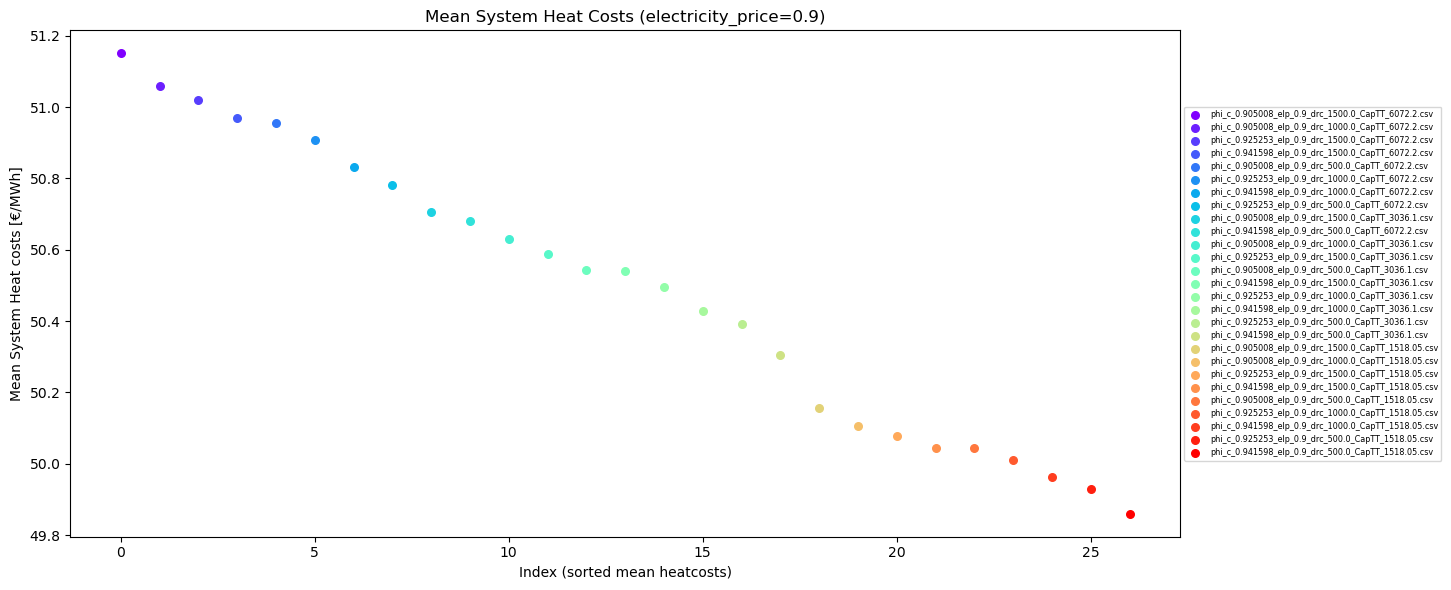

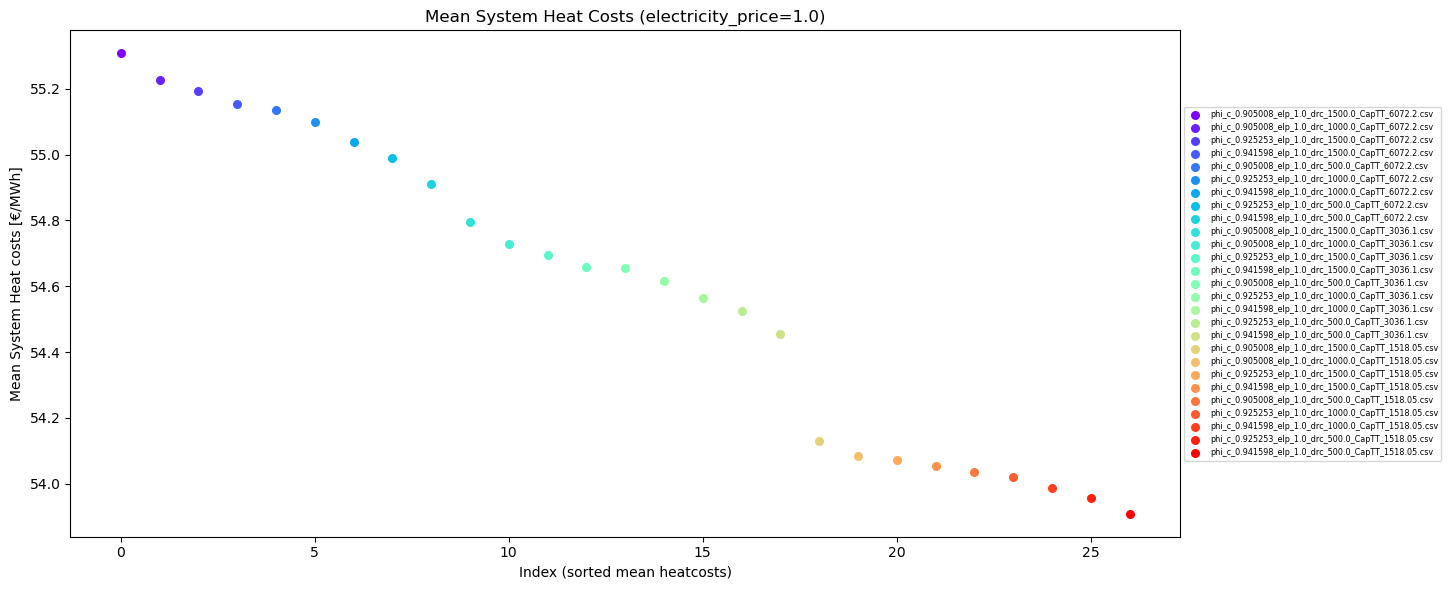

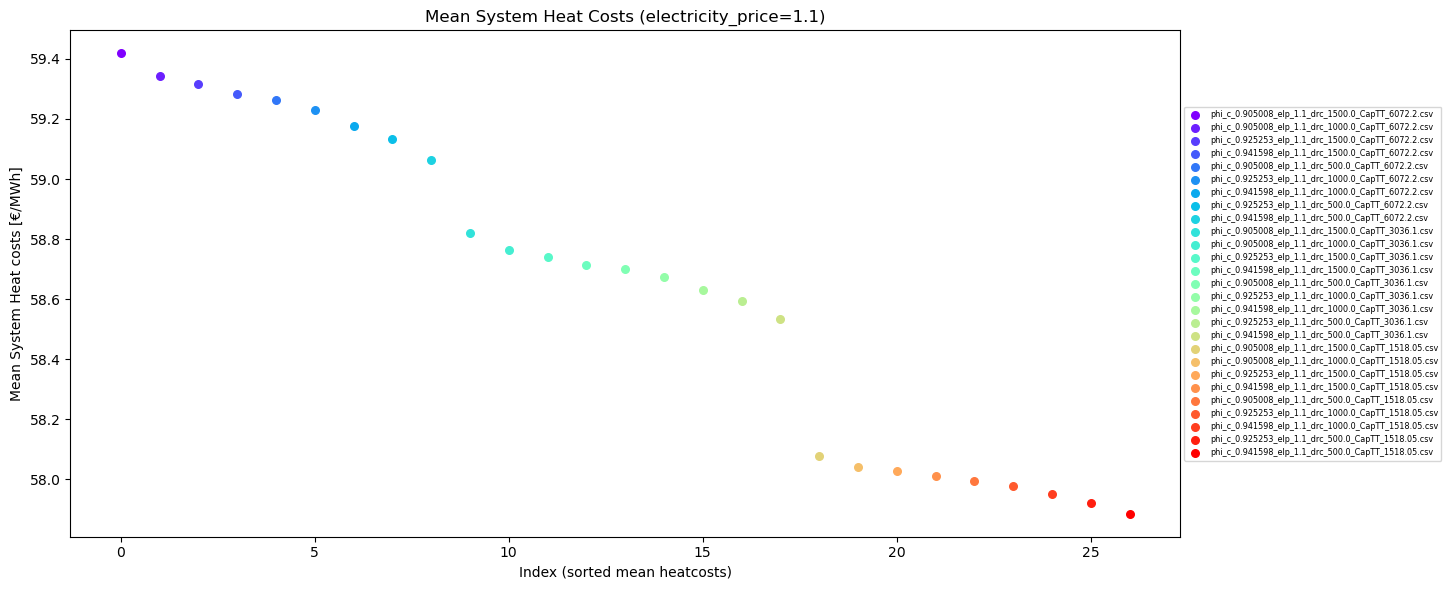

In [24]:
grouped_by_price = all_dfs.groupby('electricity_price')

for price, group in grouped_by_price:
    heatcost_means = []
    for fname in group['name']:
        df_path = os.path.join(folder, fname)
        df = pd.read_csv(df_path)
        heatcost_means.append(df['costs_per_MWh_demand'].iloc[0])

    all_energybalance = pd.DataFrame({'mean_heatcosts': heatcost_means}, index=group['name'])
    sorted_means = all_energybalance['mean_heatcosts'].sort_values(ascending=False)
    num_points = len(sorted_means)
    rainbow_cmap = matplotlib.colormaps['rainbow'].resampled(num_points)
    colors = [rainbow_cmap(i) for i in range(num_points)]

    plt.figure(figsize=(12, 6))
    for i, (name, mean_val) in enumerate(sorted_means.items()):
        plt.scatter(i, mean_val, color=colors[i], s=30, label=name)
    plt.xlabel('Index (sorted mean heatcosts)')
    plt.ylabel('Mean System Heat costs [€/MWh]')
    plt.title(f'Mean System Heat Costs (electricity_price={price})')
    plt.tight_layout()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='xx-small')
    plt.show()

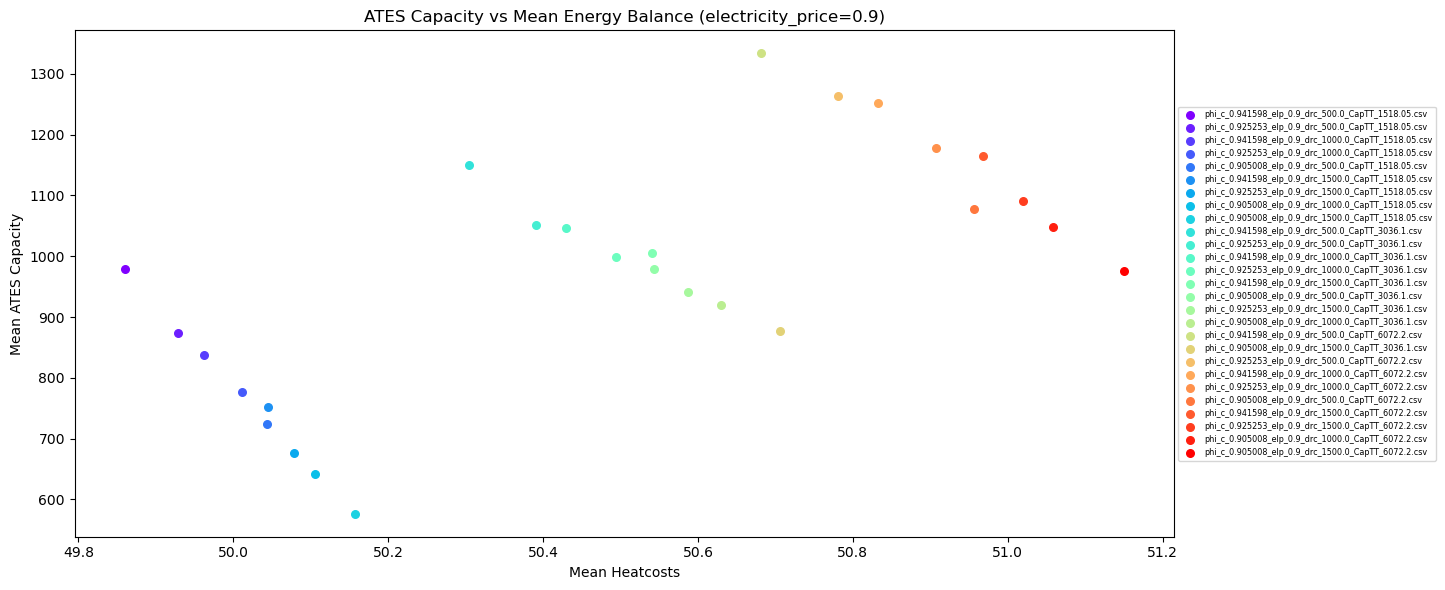

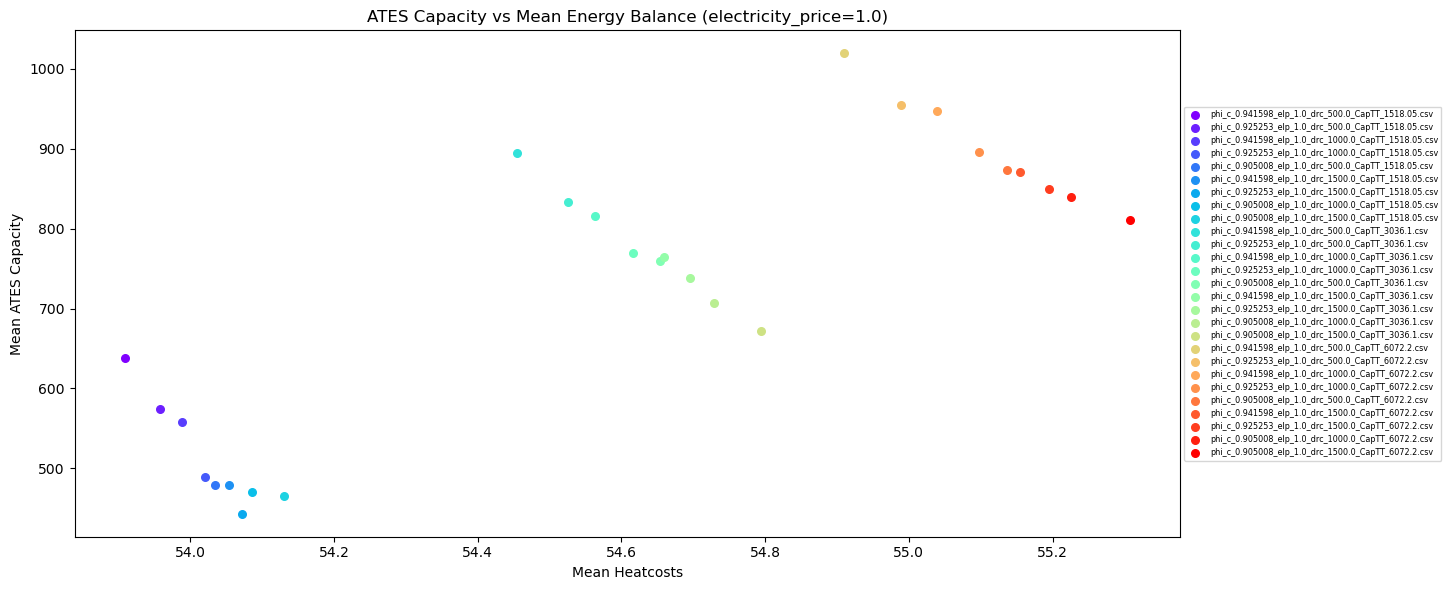

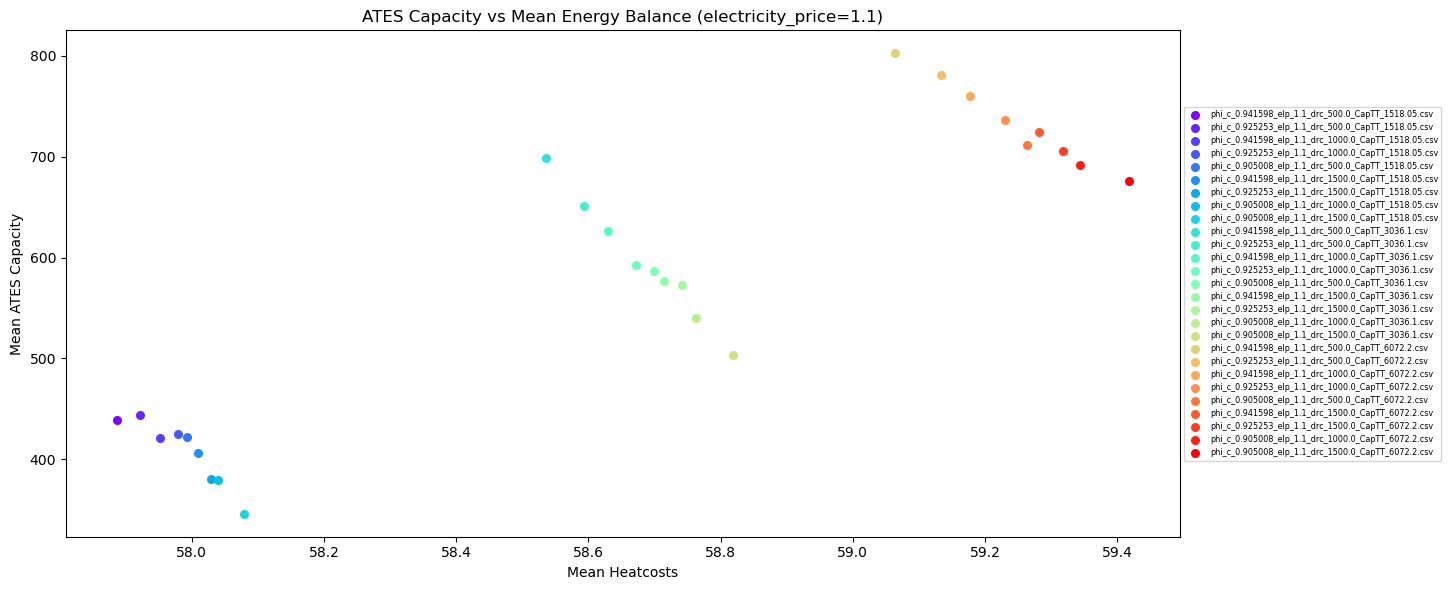

In [25]:
grouped_by_price = all_dfs.groupby('electricity_price')

for price, group in grouped_by_price:
    heatcost_means = []
    ates_capacity = []
    names = []
    for fname in group['name']:
        df_path = os.path.join(folder, fname)
        df = pd.read_csv(df_path)
        heatcost_means.append(df['costs_per_MWh_demand'].iloc[0])
        ates_capacity.append(df['ATES_capacity'].mean())
        names.append(fname)

    # Sort by mean_energy_balance
    sorted_data = sorted(zip(heatcost_means, ates_capacity, names), key=lambda x: x[0])
    sorted_mean_heatcosts, sorted_ates_capacity, sorted_names = zip(*sorted_data)

    num_points = len(sorted_mean_heatcosts)
    rainbow_cmap = matplotlib.colormaps['rainbow'].resampled(num_points)
    colors = [rainbow_cmap(i) for i in range(num_points)]

    plt.figure(figsize=(12, 6))
    for i, (x, y, name) in enumerate(zip(sorted_mean_heatcosts, sorted_ates_capacity, sorted_names)):
        plt.scatter(x, y, color=colors[i], s=30, label=name)
    plt.xlabel('Mean Heatcosts')
    plt.ylabel('Mean ATES Capacity')
    plt.title(f'ATES Capacity vs Mean Energy Balance (electricity_price={price})')
    plt.tight_layout()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='xx-small')
    plt.show()

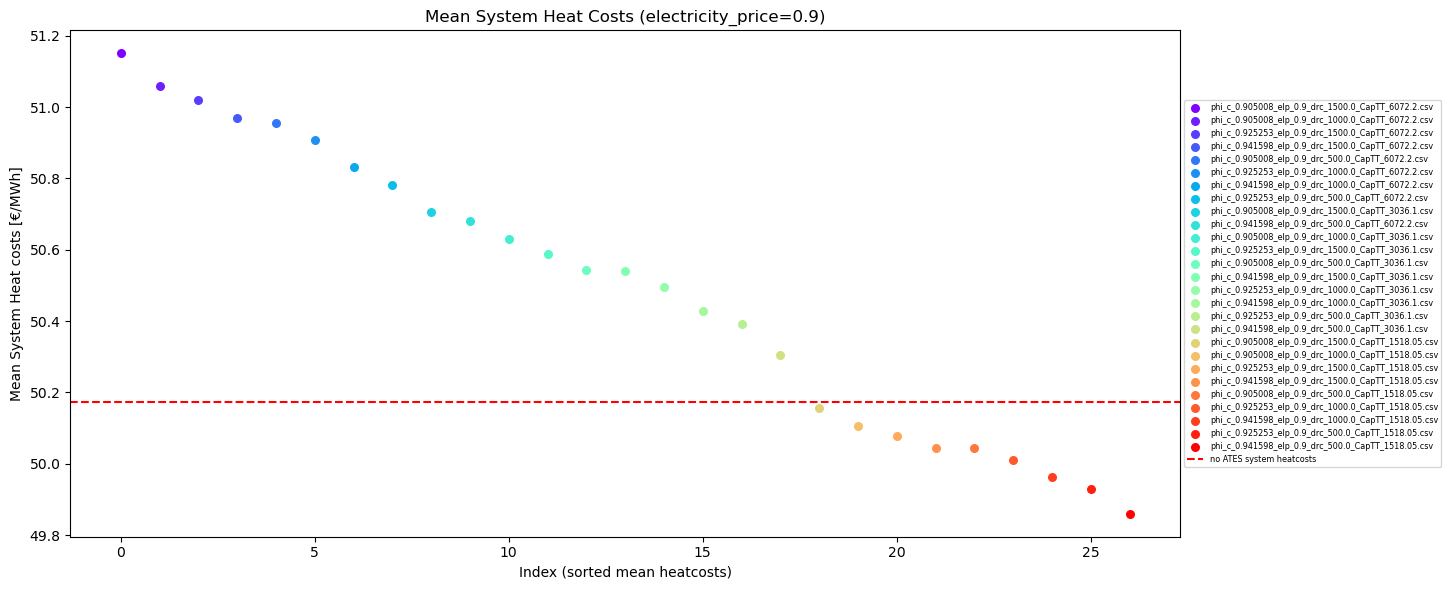

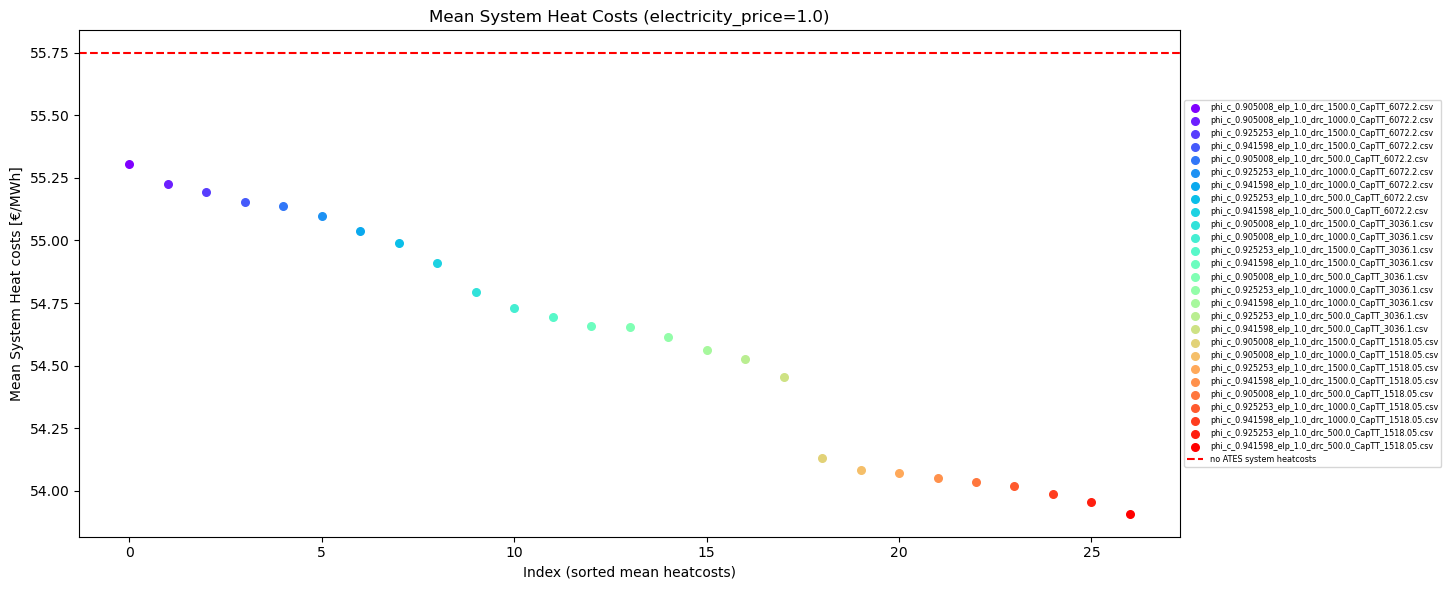

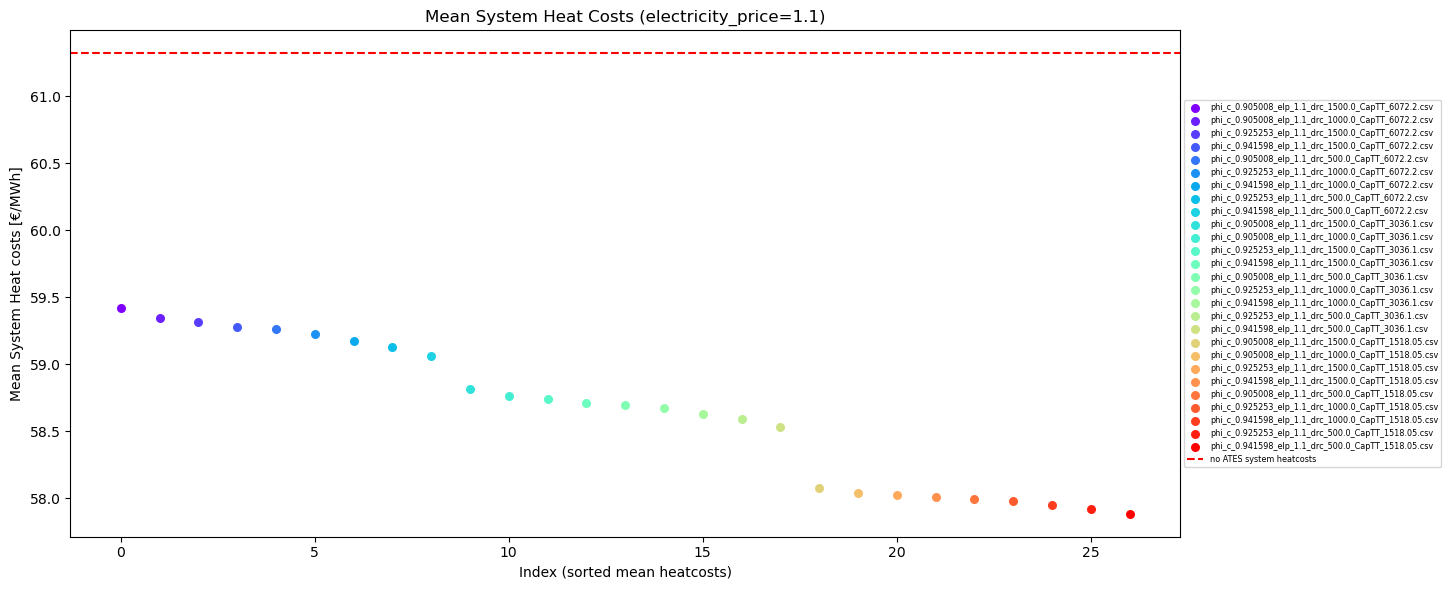

In [26]:
grouped_by_price = all_dfs.groupby('electricity_price')

# Find the no ATES case mean system heat costs for comparison
basecase_folder = "optimization_1_basecase"
basecase_files = glob.glob(os.path.join(basecase_folder, "02_*.csv"))
if basecase_files:
    basecase_df = pd.read_csv(basecase_files[0])
    basecase_mean_heatcost = basecase_df['costs_per_MWh_demand'].mean()
    #plt.axhline(basecase_mean_heatcost, color='red', linestyle='--', label='no ATES system heatcosts')



for price, group in grouped_by_price:
    heatcost_means = []
    for fname in group['name']:
        df_path = os.path.join(folder, fname)
        df = pd.read_csv(df_path)
        heatcost_means.append(df['costs_per_MWh_demand'].iloc[0])

    all_energybalance = pd.DataFrame({'mean_heatcosts': heatcost_means}, index=group['name'])
    sorted_means = all_energybalance['mean_heatcosts'].sort_values(ascending=False)
    num_points = len(sorted_means)
    rainbow_cmap = matplotlib.colormaps['rainbow'].resampled(num_points)
    colors = [rainbow_cmap(i) for i in range(num_points)]

    plt.figure(figsize=(12, 6))
    for i, (name, mean_val) in enumerate(sorted_means.items()):
        plt.scatter(i, mean_val, color=colors[i], s=30, label=name)
    
    plt.axhline(basecase_mean_heatcost*price, color='red', linestyle='--', label='no ATES system heatcosts')
    plt.xlabel('Index (sorted mean heatcosts)')
    plt.ylabel('Mean System Heat costs [€/MWh]')
    plt.title(f'Mean System Heat Costs (electricity_price={price})')
    plt.tight_layout()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='xx-small')
    plt.show()

# plt.figure(figsize=(12, 6))
# highlight_name = 'phi_s_0.999967_elp_1.0_drc_1000_CapTT_3036.csv'
# highlight_idx = None

# all_energybalance = pd.DataFrame({'mean_heatcosts': heatcost_means}, index=group['name'])
# sorted_means = all_energybalance['mean_heatcosts'].sort_values(ascending=False)
# num_points = len(sorted_means)
# rainbow_cmap = matplotlib.colormaps['rainbow'].resampled(num_points)
# colors = [rainbow_cmap(i) for i in range(num_points)]


# for i, (name, mean_val) in enumerate(sorted_means.items()):
#     if all_dfs['name'].iloc[i] == highlight_name:
#         plt.scatter(i, mean_val, color='black', s=30, label=f'basecase', zorder=10)
#         highlight_idx = i
#     else:
#         plt.scatter(i, mean_val, color=colors[i], s=30, label=name)

# if highlight_idx is not None:
#     plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='xx-small', ncol=3)
# plt.axhline(basecase_mean_heatcost, color='red', linestyle='--', label='no ATES system heatcosts')

# plt.ylabel('Mean System Heat costs [€/MWh]')
# plt.xlabel('Index (sorted mean heatcosts)')
# plt.title(f'Mean System Heat Costs for different electricity price factors (0.9 to 1.1)', fontsize=25)
# plt.tight_layout()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='xx-small', ncol=1)
# plt.show()


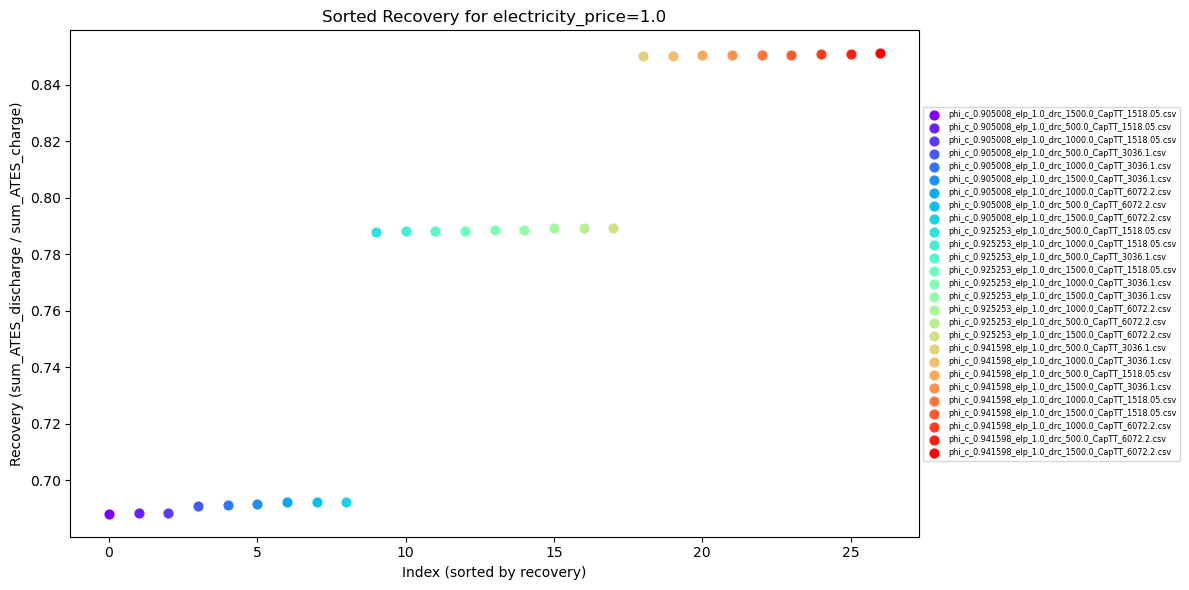

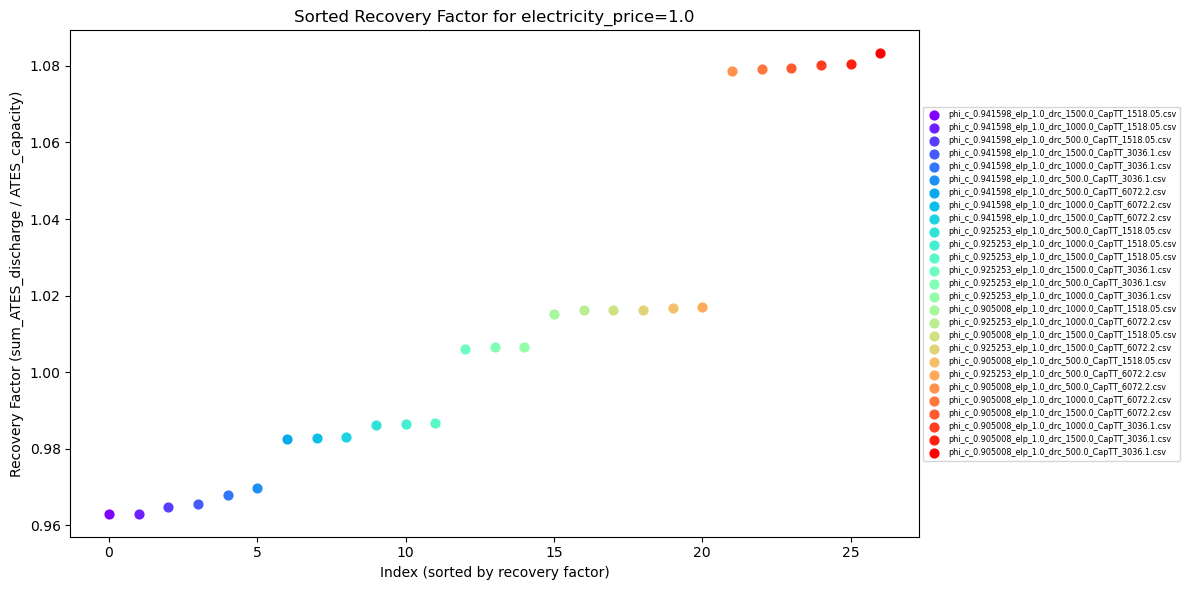

: 

In [ ]:
# Filter and assign both columns in a single step for efficiency
all_dfs_electr1 = all_dfs[all_dfs['electricity_price'] == 1.0].copy()
all_dfs_electr1['recovery'] = all_dfs_electr1['ATES_discharge_sum'] / all_dfs_electr1['ATES_charge_sum']
all_dfs_electr1['recov_fac'] = all_dfs_electr1['ATES_charge_sum'] / all_dfs_electr1['ATES_capacity']

num_points = len(all_dfs_electr1)
rainbow_cmap = matplotlib.colormaps['rainbow'].resampled(num_points)
colors = [rainbow_cmap(i) for i in range(num_points)]


# Sorted recovery plot
plt.figure(figsize=(12, 6))
sorted_recovery = all_dfs_electr1.sort_values('recovery')
for i, (idx, row) in enumerate(sorted_recovery.iterrows()):
    plt.scatter(i, row['recovery'], color=colors[i], s=40, label=row['name'])
plt.xlabel('Index (sorted by recovery)')
plt.ylabel('Recovery (sum_ATES_discharge / sum_ATES_charge)')
plt.title('Sorted Recovery for electricity_price=1.0')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='xx-small')
plt.tight_layout()
plt.show()

# Sorted recovery factor plot
plt.figure(figsize=(12, 6))
sorted_recov_fac = all_dfs_electr1.sort_values('recov_fac')
for i, (idx, row) in enumerate(sorted_recov_fac.iterrows()):
    plt.scatter(i, row['recov_fac'], color=colors[i], s=40, label=row['name'])
plt.xlabel('Index (sorted by recovery factor)')
plt.ylabel('Recovery Factor (sum_ATES_discharge / ATES_capacity)')
plt.title('Sorted Recovery Factor for electricity_price=1.0')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='xx-small')
plt.tight_layout()
plt.show()